In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import jax
from jax import grad, jit
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
import time
import cma
from scipy.stats import qmc
import corner
from vbmc_utils import *

### Ring shape density example 
$$
p(x,y) = \frac{1}{2 \pi \sigma r_0} \exp\Bigg\{ -\frac{(r - r_0)^2}{2\sigma^2} \Bigg\}, 
\quad x, y \in \mathbb{R}.
$$

In [2]:
def expensive_log_likelihood(obs, params):
    x = obs[:, 0]
    y = obs[:, 1]
    r0, sigma = params

    r = jnp.sqrt(x**2 + y**2)
    likelihood = jnp.exp(-0.5 * ((r - r0) / sigma)**2) / (2 * jnp.pi * sigma * r0)
    return jnp.log(likelihood + 1e-12)


params_true = (2.0,0.2)

In [13]:
def vbmc(grad_elbo, d, PLB, PUB, lower, upper, n_initial,
         alpha=1, beta=1, gamma=1, lr=0.005, k=2, 
          n_points=1,rsp=5, n1=10, n2=20_000, 
          plots=True, ll=None, params_true=None, key=None, fullsig=True):
    
    print("Beginning Warmup Phase")
    print()
    
    #initialise
    print(f"Sampling first {n_initial} points and Initialising Mixture")
    print()
    x, y, params = initialise(params_true, ll, d=d, lower=PLB, upper=PUB, n=n_initial, k=k, key=key,fullsig=fullsig)
    x1,y1 = reshape(x, y)
    max_range = upper-lower

    #draw gp hp samples
    n_gp_hp = 10
    print(f"Collecting {n_gp_hp} Hyperparameter Samples for first Iter")
    sampler, hp_samples = gp_hp(x1,y1,n_samples=n_gp_hp, chainlength=1500, discard=500)
    hp1 = (hp_samples[0][0], 
           hp_samples[1][0],
           hp_samples[2][0],
           hp_samples[3][0],
           hp_samples[4][0],
           hp_samples[5][0])
    chol_k, K_inv = kinv(x1, hp_samples=hp_samples)

    if plots:
        print(f"Plot Before Iter 1")
        print()
        plot_plots(params, params_true, x_points=x1, n_new=0, likelihood_fn=ll, fullsig=fullsig)
        np = n_points
    warmup=True
    fixed_weights = True
    fw = 0
    elbo_history = []
    elcbo_history = []
    best_elcbo = -jnp.inf
    np = n_points

    current_elbo, var = elbo(params,x1,y1, hp_samples,chol_ks=chol_k, key=key, random=False, fullsig=fullsig)
    current_elbo = -current_elbo
    
    for j in range(n1):
        print(f"Beggining Iter {j+1}")
        nfast = jnp.where(warmup, 50, 25)
        params = jitter(nfast, params, x1, y1, 
                        hp_samples, max_range, current_elbo, 
                        chol_ks=chol_k, key=key,warmup=warmup, fullsig=fullsig)

        for i in range(n2):
            key, _ = jax.random.split(key)
            w_l_r = jnp.where(fixed_weights, 0.0, 0.1)
            if i > (n2 - n2/8):
                grads = grad_elbo(params,x1,y1, hp_samples,chol_ks=chol_k, key=key, fullsig=fullsig)
                logitweights = params[2] - w_l_r*lr*grads[2]
                params = tuple(p - lr*g for p, g in zip(params[:2], grads[:2]))
            else:
                grads = grad_elbo(params,x1,y1, hp_samples,chol_ks=chol_k, key=key, fullsig=fullsig)
                logitweights = params[2]
                params = tuple(p - lr*g for p, g in zip(params[:2], grads[:2]))
                

            params = (params[0], params[1], logitweights)                

            if (i+1) % (n2/8) == 0:
                current_elbo, var = elbo(params,x1,y1, hp_samples,chol_ks=chol_k, key=key, random=False, fullsig=fullsig)
                current_elbo = -current_elbo
                current_elcbo = current_elbo - rsp*jnp.sqrt(var)
                
                elbo_history.append(current_elbo)
                elcbo_history.append(current_elcbo)


                print(f"Iter {j+1}, {i+1}: ELBO = {current_elbo:.4f}, ELCBO = {current_elcbo:.4f}")


        #check to end warmup
        if warmup and len(elcbo_history) >= 17:
            improvement1 = elcbo_history[-1-7-1] - elcbo_history[-1-7-1-7]
            improvement2 = elcbo_history[-1-7] - elcbo_history[-1-7-1]
            improvement3 = elcbo_history[-1] - elcbo_history[-1-7]
            if 0 < improvement1 < 1.5 and 0 < improvement2 < 1.5  and 0 < improvement3 < 1.5:
                print("Improvement is positive and less than 1.5 for three consecutive iterations")
                #trim points after warmup
                x1, y1, chol_K, K_inv = trim(x,y,hp_samples)
                fw = 1

        #no adding, removing or sampling after last iter
        if j != (n1-1):

            #when to remove
            if not fixed_weights and k > d:
                params, k = remove(params)

            #no sample after pruning mixture
            if not warmup or fw == 0:
                print()
                print(f"Beginning active sampling for next Iter")
                x, y = active_sample(x1,y1,hp_samples,K_inv,
                                        alpha, beta, gamma, params_true,
                                        params, ll,  n_points, lower, upper, fullsig=fullsig)
                x1,y1 = reshape(x, y)
                print(f"Completed active sampling for next Iter")
                print()
            else:
                np = 0
                fw = 0
                warmup = False

            #when to add
            if not warmup:
                params, k = add(params, key, fullsig=fullsig)
                alpha, beta, gamma, lr = 1.3, 0.3, 0.4, 0.011
                n_points = 5
                fw += 1

            if plots:
                print(f"Plot After Iter {j+1} showing new training points")
                print()
                plot_plots(params, params_true, x_points=x1, n_new=np, likelihood_fn=ll, fullsig=fullsig)
                np = n_points

            
            #draw gp hp samples
            if fw < (d + 5): 
                n_gp_hp = jnp.where(warmup,10, int(80*len(y)**(-0.75)))
            else:
                n_gp_hp = 1
            print(f"Collecting {n_gp_hp} Hyperparameter Samples for next Iter")
            print()
            sampler, hp_samples = gp_hp(x1,y1,n_samples=n_gp_hp, 
                                prev_sampler=sampler,
                                chainlength=int(80*n_gp_hp), 
                                discard=int(6*n_gp_hp))


            hp1 = (hp_samples[0][0], 
                   hp_samples[1][0],
                   hp_samples[2][0],
                   hp_samples[3][0],
                   hp_samples[4][0],
                   hp_samples[5][0])
            chol_k, K_inv = kinv(x1, hp_samples=hp_samples)

            if fw > d and fixed_weights:
                print("Weights now free to move")
                fixed_weights = False
    if plots:
        plot_plots(params, params_true, x_points=x1, n_new=0, likelihood_fn=ll, fullsig=fullsig)


    return params, elbo_history, elcbo_history

Beginning Warmup Phase

Sampling first 8 points and Initialising Mixture



100%|██████████| 1500/1500 [00:42<00:00, 35.00it/s]


Plot Before Iter 1



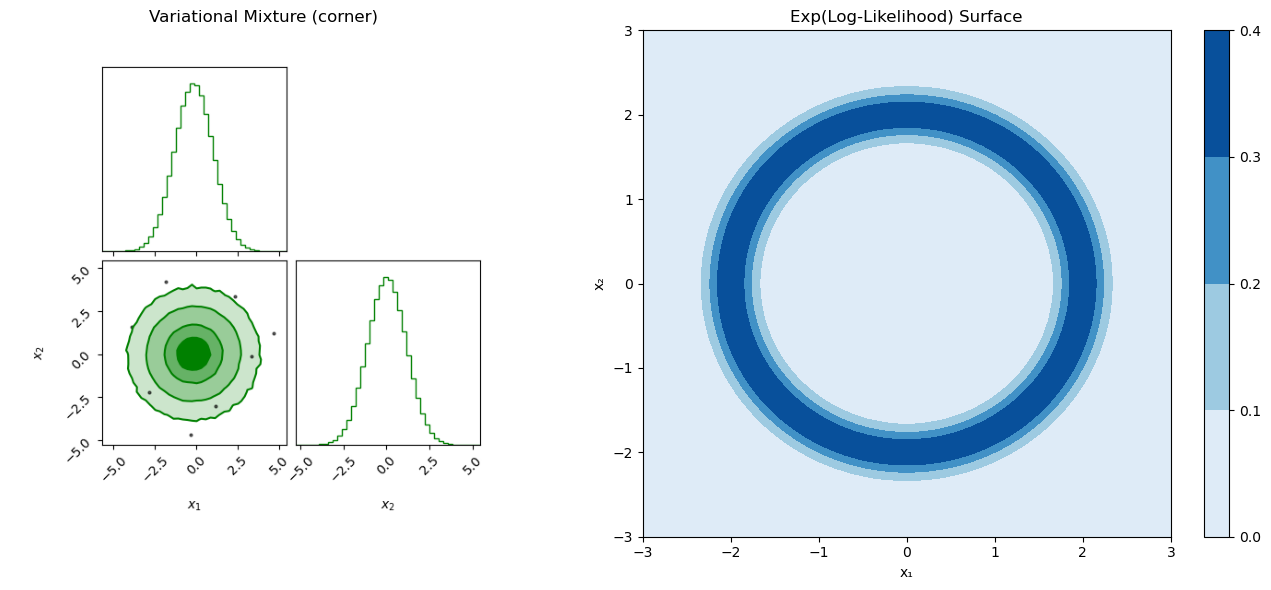

Beggining Iter 1
Jittered Candidate Selected
Iter 1, 1250: ELBO = -19.9698, ELCBO = -32.1267
Iter 1, 2500: ELBO = -19.9189, ELCBO = -31.6168
Iter 1, 3750: ELBO = -19.8909, ELCBO = -31.2101
Iter 1, 5000: ELBO = -19.8710, ELCBO = -30.8760
Iter 1, 6250: ELBO = -19.8484, ELCBO = -30.5896
Iter 1, 7500: ELBO = -19.8474, ELCBO = -30.3684
Iter 1, 8750: ELBO = -19.8358, ELCBO = -30.1713
Iter 1, 10000: ELBO = -19.8238, ELCBO = -30.0023

Beginning active sampling for next Iter
Point 1 of 6
Point 2 of 6
Point 3 of 6
Point 4 of 6
Point 5 of 6
Point 6 of 6
Completed active sampling for next Iter

Plot After Iter 1 showing new training points



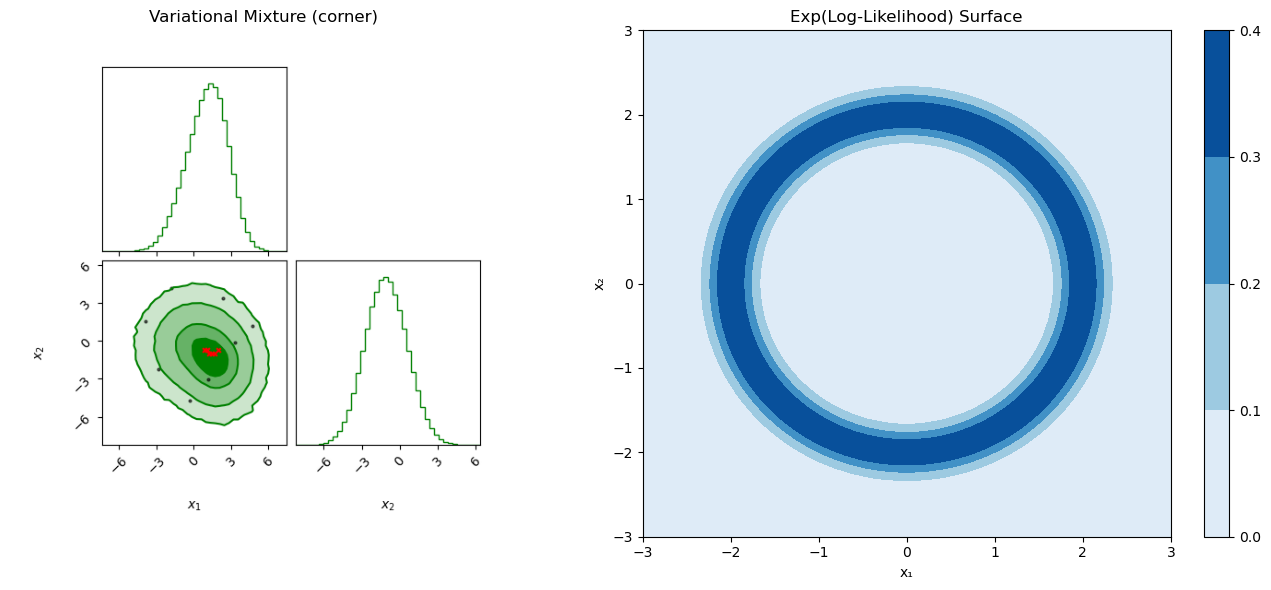

100%|██████████| 800/800 [00:21<00:00, 37.05it/s]


Beggining Iter 2
Jittered Candidate Selected
Iter 2, 1250: ELBO = -10.3717, ELCBO = -27.5131
Iter 2, 2500: ELBO = -5.2824, ELCBO = -16.7780
Iter 2, 3750: ELBO = -2.7371, ELCBO = -7.4713
Iter 2, 5000: ELBO = -1.9561, ELCBO = -5.7193
Iter 2, 6250: ELBO = -1.7010, ELCBO = -5.9738
Iter 2, 7500: ELBO = -1.5989, ELCBO = -6.2790
Iter 2, 8750: ELBO = -1.5615, ELCBO = -6.5046
Iter 2, 10000: ELBO = -1.5287, ELCBO = -6.6333

Beginning active sampling for next Iter
Point 1 of 6
Point 2 of 6
Point 3 of 6
Point 4 of 6
Point 5 of 6
Point 6 of 6
Completed active sampling for next Iter

Plot After Iter 2 showing new training points



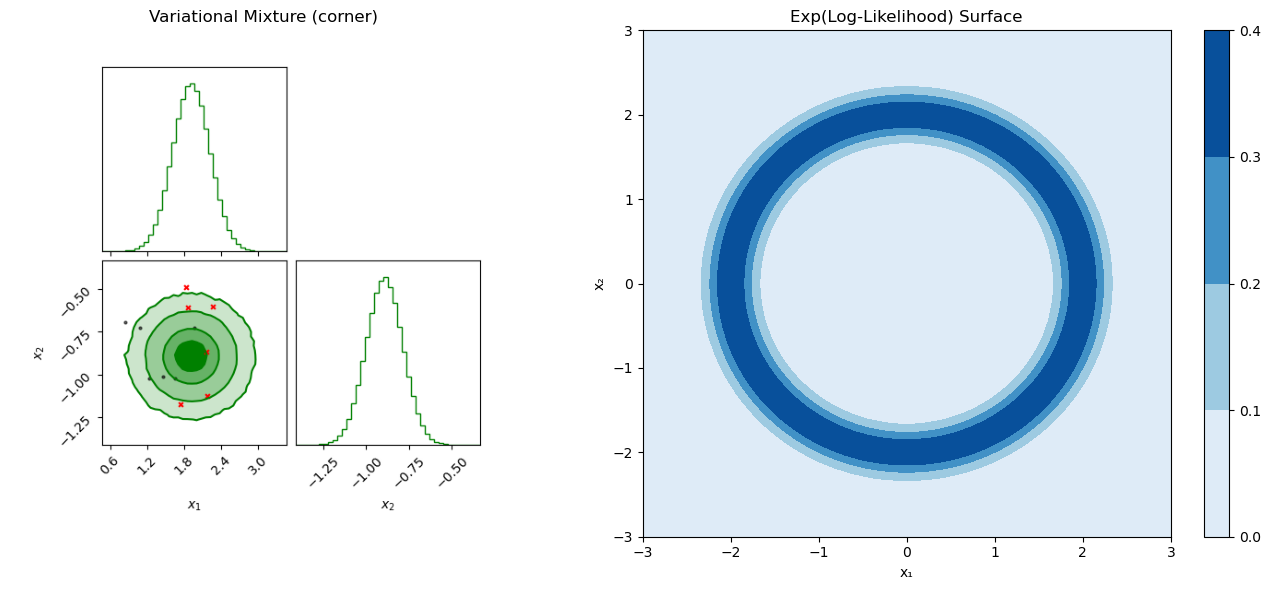

  0%|          | 0/800 [00:00<?, ?it/s]c:\Users\gmedw\miniconda3\envs\pgmpy_env\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 800/800 [00:21<00:00, 37.17it/s]


Beggining Iter 3
Iter 3, 1250: ELBO = -1.5794, ELCBO = -1.8816
Iter 3, 2500: ELBO = -1.4582, ELCBO = -1.8282
Iter 3, 3750: ELBO = -1.3562, ELCBO = -1.7435
Iter 3, 5000: ELBO = -1.2750, ELCBO = -1.6826
Iter 3, 6250: ELBO = -1.2162, ELCBO = -1.6783
Iter 3, 7500: ELBO = -1.1604, ELCBO = -1.6870
Iter 3, 8750: ELBO = -1.1283, ELCBO = -1.7279
Iter 3, 10000: ELBO = -1.0888, ELCBO = -1.7583

Beginning active sampling for next Iter
Point 1 of 6
Point 2 of 6
Point 3 of 6
Point 4 of 6
Point 5 of 6
Point 6 of 6
Completed active sampling for next Iter

Plot After Iter 3 showing new training points



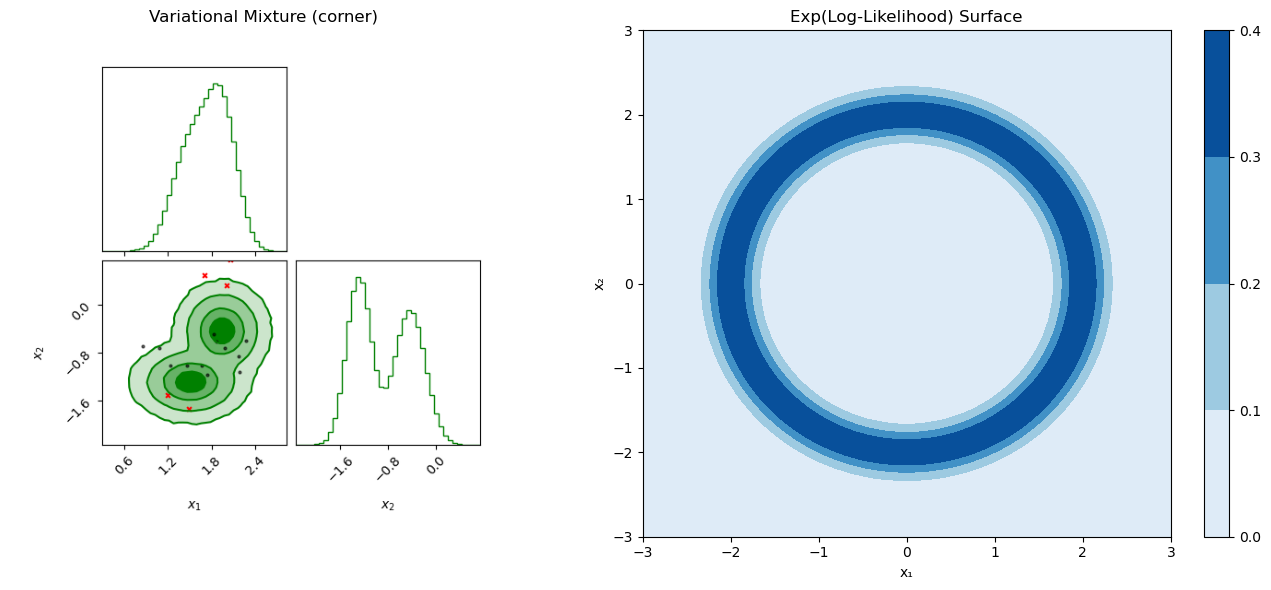

  0%|          | 0/800 [00:00<?, ?it/s]c:\Users\gmedw\miniconda3\envs\pgmpy_env\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 800/800 [00:30<00:00, 26.35it/s]


Beggining Iter 4
Iter 4, 1250: ELBO = -0.8916, ELCBO = -1.0007
Iter 4, 2500: ELBO = -0.8202, ELCBO = -0.9404
Iter 4, 3750: ELBO = -0.7633, ELCBO = -0.8858
Iter 4, 5000: ELBO = -0.7114, ELCBO = -0.8292
Iter 4, 6250: ELBO = -0.6689, ELCBO = -0.7766
Iter 4, 7500: ELBO = -0.6377, ELCBO = -0.7356
Iter 4, 8750: ELBO = -0.6285, ELCBO = -0.7209
Iter 4, 10000: ELBO = -0.6217, ELCBO = -0.7115
Improvement is positive and less than 1.5 for three consecutive iterations
Trimming 8 points

Warm up phase complete:

Plot After Iter 4 showing new training points



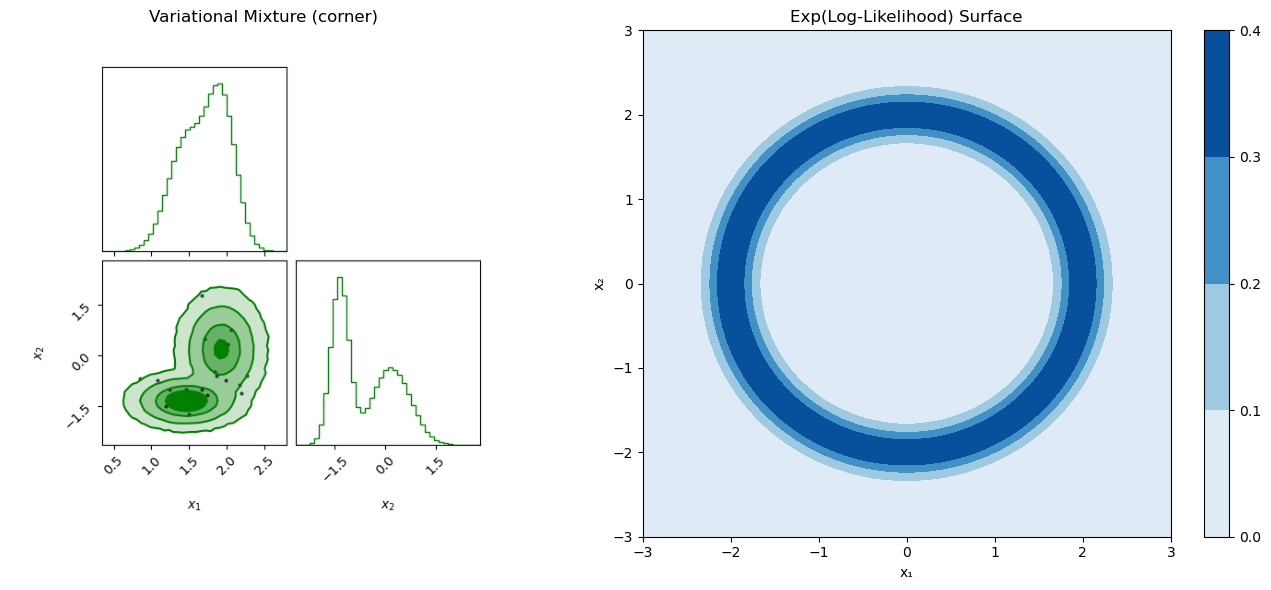

Adding new component.



  0%|          | 0/480 [00:00<?, ?it/s]c:\Users\gmedw\miniconda3\envs\pgmpy_env\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 480/480 [00:10<00:00, 47.92it/s]


Beggining Iter 5
Iter 5, 1250: ELBO = -0.4765, ELCBO = -0.6307
Iter 5, 2500: ELBO = -0.4661, ELCBO = -0.6232
Iter 5, 3750: ELBO = -0.4648, ELCBO = -0.6269
Iter 5, 5000: ELBO = -0.4620, ELCBO = -0.6255
Iter 5, 6250: ELBO = -0.4663, ELCBO = -0.6343
Iter 5, 7500: ELBO = -0.4666, ELCBO = -0.6334
Iter 5, 8750: ELBO = -0.4660, ELCBO = -0.6330
Iter 5, 10000: ELBO = -0.4651, ELCBO = -0.6318

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Plot After Iter 5 showing new training points



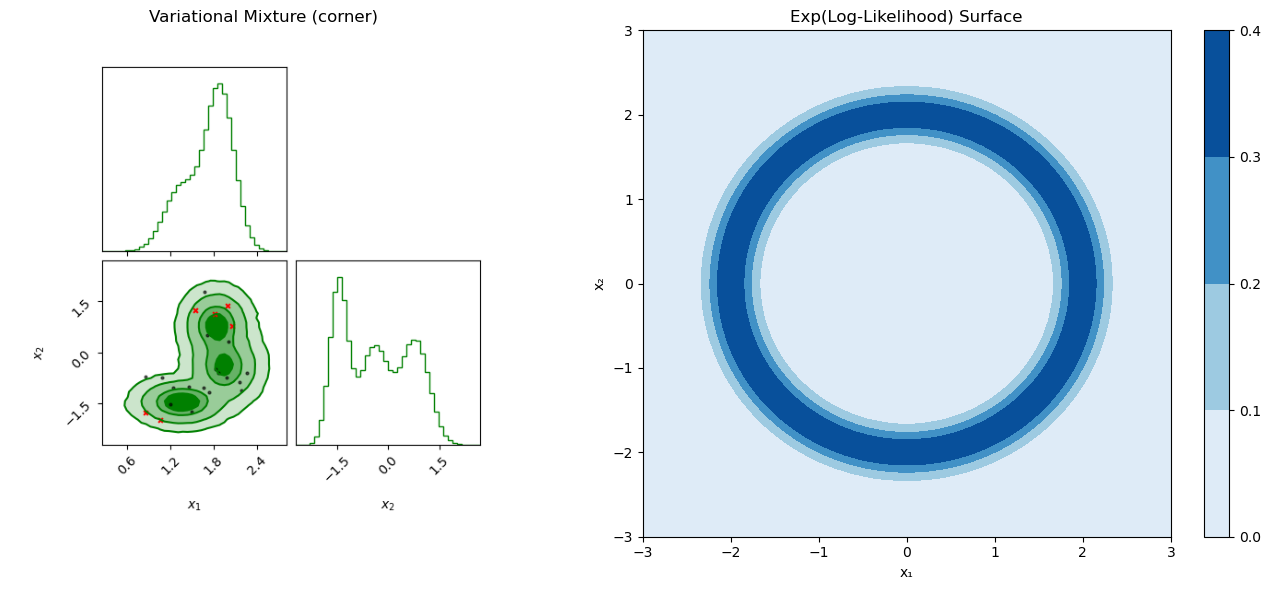

Adding new component.



  0%|          | 0/560 [00:00<?, ?it/s]c:\Users\gmedw\miniconda3\envs\pgmpy_env\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 560/560 [00:15<00:00, 37.30it/s]


Beggining Iter 6
Iter 6, 1250: ELBO = -0.2296, ELCBO = -0.6305
Iter 6, 2500: ELBO = -0.2239, ELCBO = -0.6238
Iter 6, 3750: ELBO = -0.2246, ELCBO = -0.6390
Iter 6, 5000: ELBO = -0.2205, ELCBO = -0.6123
Iter 6, 6250: ELBO = -0.2249, ELCBO = -0.6232
Iter 6, 7500: ELBO = -0.2182, ELCBO = -0.6089
Iter 6, 8750: ELBO = -0.2221, ELCBO = -0.6228
Iter 6, 10000: ELBO = -0.2212, ELCBO = -0.6231

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Plot After Iter 6 showing new training points



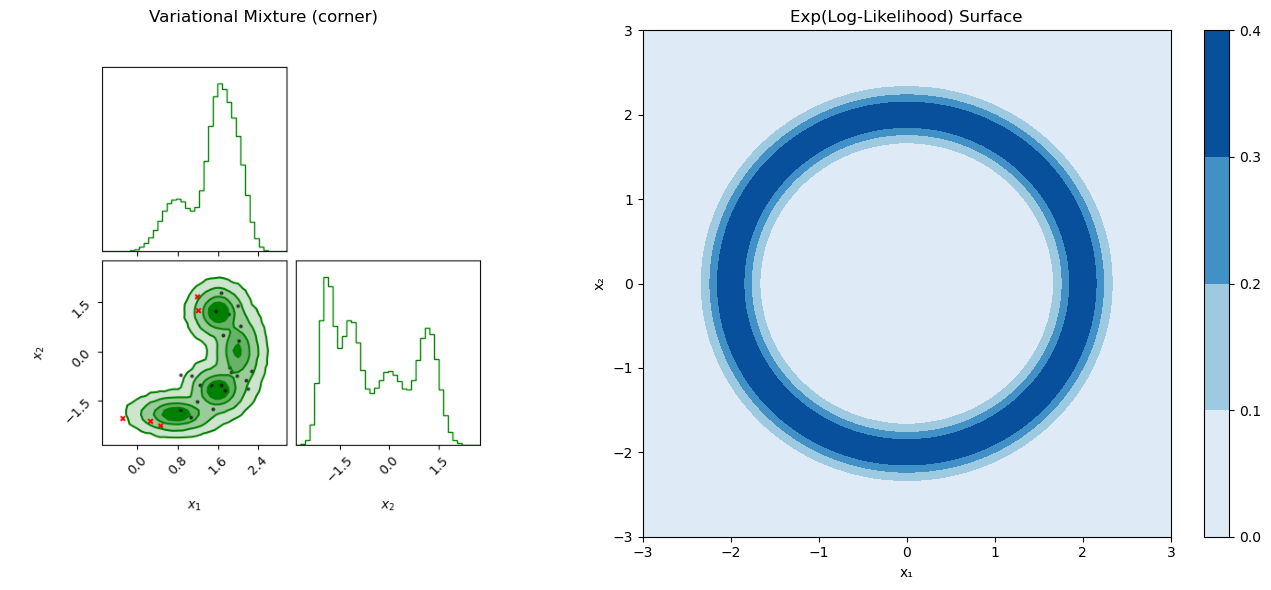

Adding new component.



  0%|          | 0/480 [00:00<?, ?it/s]c:\Users\gmedw\miniconda3\envs\pgmpy_env\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 480/480 [00:17<00:00, 27.90it/s]


Weights now free to move
Beggining Iter 7
Jittered Candidate Selected
Iter 7, 1250: ELBO = 0.5018, ELCBO = -4.5067
Iter 7, 2500: ELBO = 0.6358, ELCBO = -8.3551
Iter 7, 3750: ELBO = 0.6611, ELCBO = -8.5143
Iter 7, 5000: ELBO = 0.6726, ELCBO = -8.6666
Iter 7, 6250: ELBO = 0.6901, ELCBO = -9.1366
Iter 7, 7500: ELBO = 0.7355, ELCBO = -10.3929
Iter 7, 8750: ELBO = 0.7483, ELCBO = -11.2755
Iter 7, 10000: ELBO = 0.8188, ELCBO = -12.8398
Current Weights:
[0.2048448  0.20167917 0.17051586 0.2612815  0.16167868]

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Plot After Iter 7 showing new training points



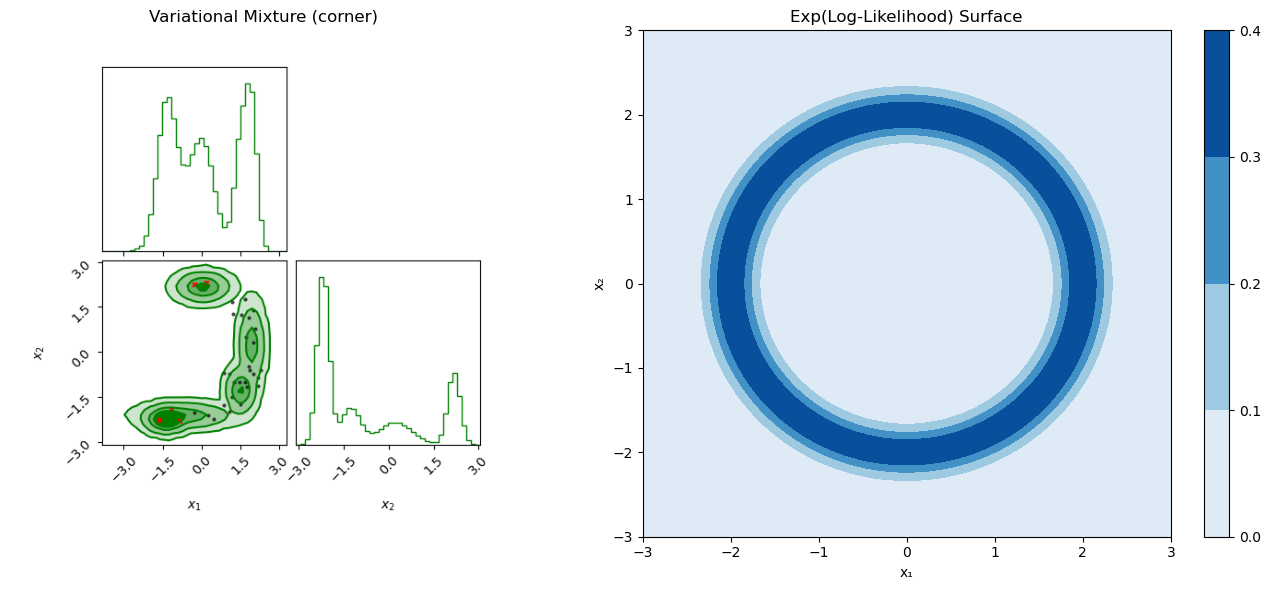

Adding new component.



  0%|          | 0/400 [00:00<?, ?it/s]c:\Users\gmedw\miniconda3\envs\pgmpy_env\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 400/400 [00:14<00:00, 27.27it/s]


Beggining Iter 8
Iter 8, 1250: ELBO = 0.1825, ELCBO = -0.2174
Iter 8, 2500: ELBO = 0.2373, ELCBO = -0.1613
Iter 8, 3750: ELBO = 0.2581, ELCBO = -0.1438
Iter 8, 5000: ELBO = 0.2686, ELCBO = -0.1336
Iter 8, 6250: ELBO = 0.2704, ELCBO = -0.1385
Iter 8, 7500: ELBO = 0.2726, ELCBO = -0.1307
Iter 8, 8750: ELBO = 0.2801, ELCBO = -0.1305
Iter 8, 10000: ELBO = 0.2831, ELCBO = -0.1147
Current Weights:
[0.16949366 0.1716415  0.15049079 0.22476714 0.13982201 0.1437849 ]

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Plot After Iter 8 showing new training points



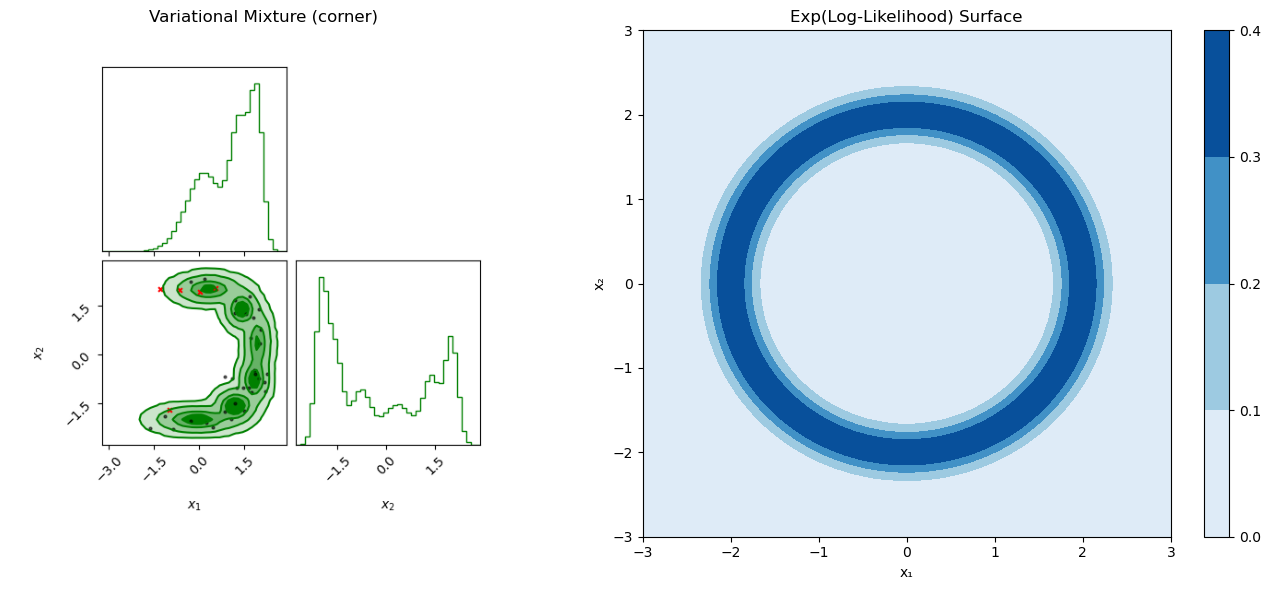

Adding new component.



100%|██████████| 400/400 [00:15<00:00, 25.47it/s]


Beggining Iter 9
Iter 9, 1250: ELBO = 0.3921, ELCBO = 0.3246
Iter 9, 2500: ELBO = 0.4016, ELCBO = 0.3295
Iter 9, 3750: ELBO = 0.4105, ELCBO = 0.3355
Iter 9, 5000: ELBO = 0.4162, ELCBO = 0.3386
Iter 9, 6250: ELBO = 0.4202, ELCBO = 0.3402
Iter 9, 7500: ELBO = 0.4259, ELCBO = 0.3441
Iter 9, 8750: ELBO = 0.4250, ELCBO = 0.3424
Iter 9, 10000: ELBO = 0.4246, ELCBO = 0.3388
Current Weights:
[0.14361891 0.14659355 0.12745697 0.19053244 0.1232809  0.12343924
 0.14507799]

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Plot After Iter 9 showing new training points



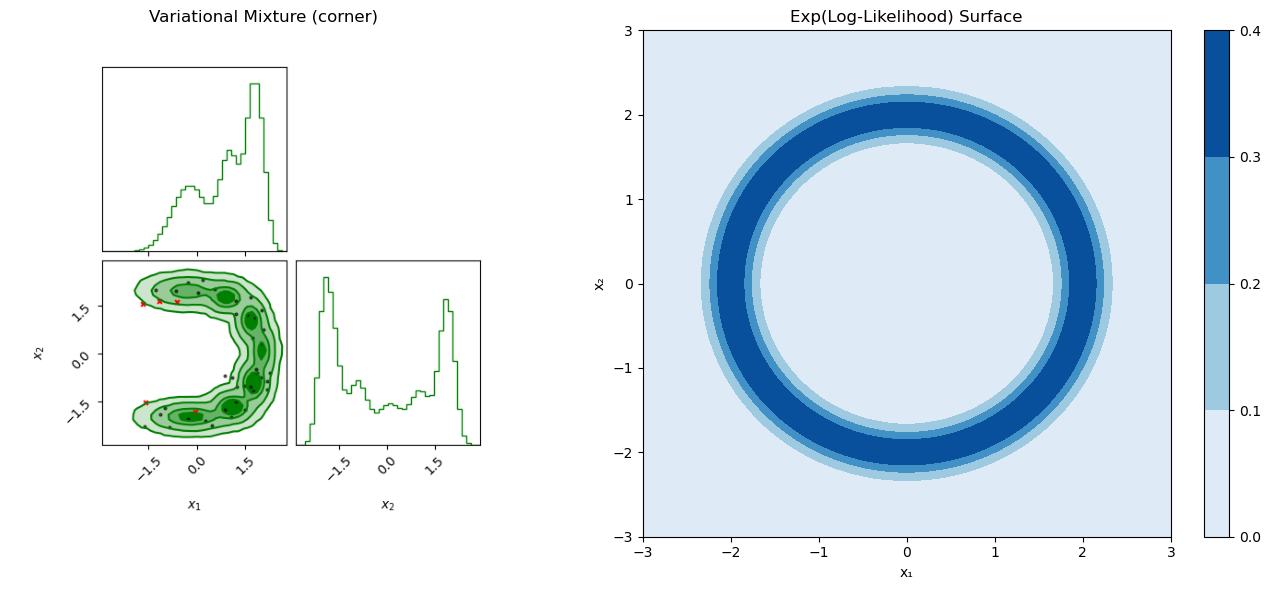

Adding new component.



100%|██████████| 320/320 [00:14<00:00, 22.42it/s]


Beggining Iter 10
Iter 10, 1250: ELBO = 0.5008, ELCBO = 0.4571
Iter 10, 2500: ELBO = 0.5164, ELCBO = 0.4594
Iter 10, 3750: ELBO = 0.5395, ELCBO = 0.3218
Iter 10, 5000: ELBO = 0.5905, ELCBO = -0.6129
Iter 10, 6250: ELBO = 0.6714, ELCBO = -2.3431
Iter 10, 7500: ELBO = 0.7159, ELCBO = -2.2138
Iter 10, 8750: ELBO = 0.7210, ELCBO = -2.0080
Iter 10, 10000: ELBO = 0.7352, ELCBO = -2.0892
Current Weights:
[0.13469338 0.12672552 0.10935554 0.16537052 0.10964011 0.10728926
 0.12443544 0.12249023]

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Plot After Iter 10 showing new training points



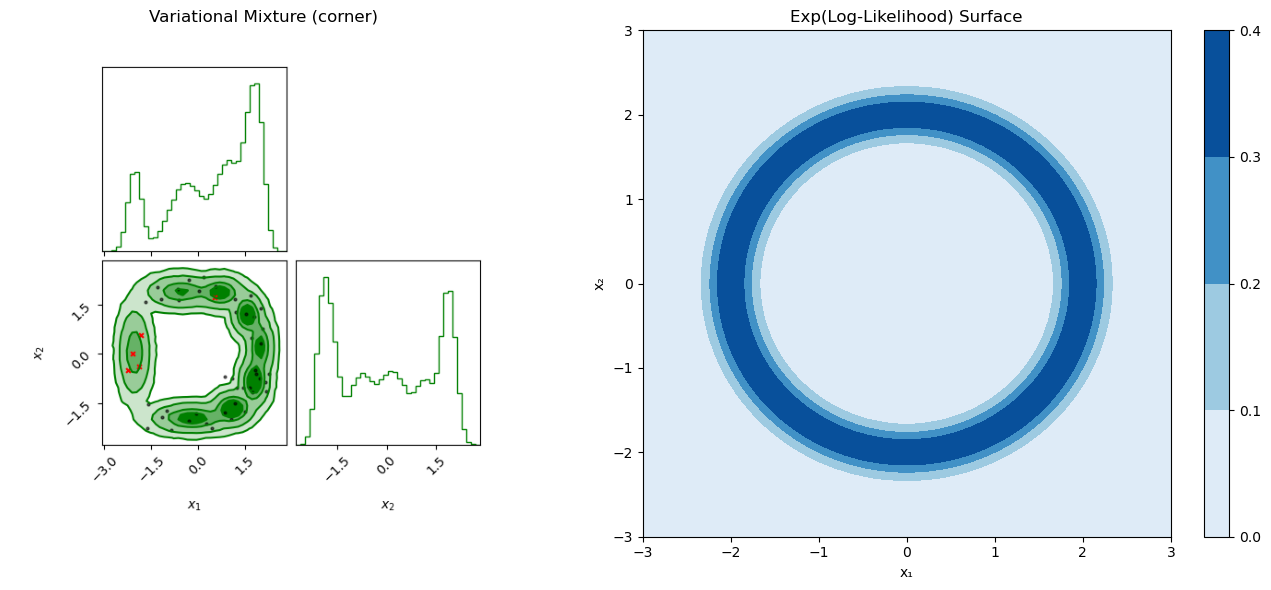

Adding new component.



100%|██████████| 80/80 [00:03<00:00, 23.07it/s]


Beggining Iter 11
Iter 11, 1250: ELBO = 0.6637, ELCBO = 0.5897
Iter 11, 2500: ELBO = 0.6725, ELCBO = 0.5976
Iter 11, 3750: ELBO = 0.6752, ELCBO = 0.5989
Iter 11, 5000: ELBO = 0.6916, ELCBO = 0.6145
Iter 11, 6250: ELBO = 0.6946, ELCBO = 0.6153
Iter 11, 7500: ELBO = 0.6961, ELCBO = 0.6144
Iter 11, 8750: ELBO = 0.7061, ELCBO = 0.6189
Iter 11, 10000: ELBO = 0.7111, ELCBO = 0.6185
Current Weights:
[0.11480657 0.1098678  0.09296    0.13766587 0.09529159 0.09385392
 0.10629462 0.10249154 0.1467681 ]

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Plot After Iter 11 showing new training points



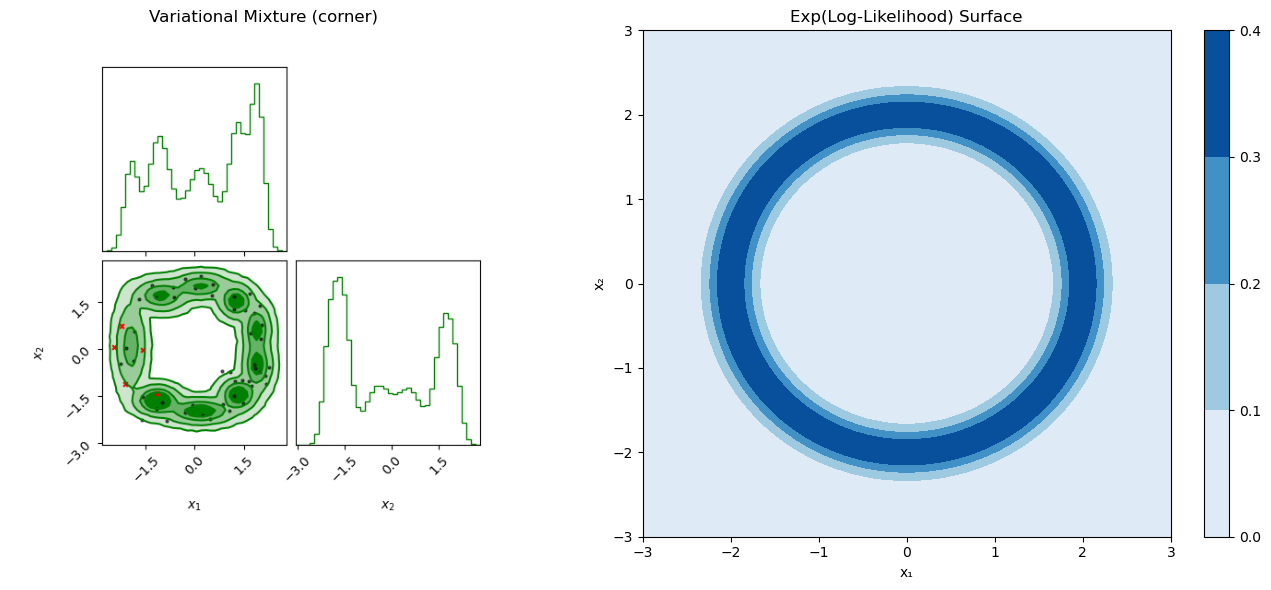

Adding new component.



100%|██████████| 80/80 [00:03<00:00, 23.91it/s]


Beggining Iter 12
Iter 12, 1250: ELBO = 0.7584, ELCBO = 0.7296
Iter 12, 2500: ELBO = 0.7751, ELCBO = 0.7461
Iter 12, 3750: ELBO = 0.7796, ELCBO = 0.7491
Iter 12, 5000: ELBO = 0.7799, ELCBO = 0.7485
Iter 12, 6250: ELBO = 0.7789, ELCBO = 0.7467
Iter 12, 7500: ELBO = 0.7823, ELCBO = 0.7493
Iter 12, 8750: ELBO = 0.7826, ELCBO = 0.7486
Iter 12, 10000: ELBO = 0.7816, ELCBO = 0.7480
Current Weights:
[0.10567136 0.10064868 0.08471291 0.12385751 0.08853102 0.0868658
 0.09656727 0.09176322 0.1358783  0.08550393]

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Plot After Iter 12 showing new training points



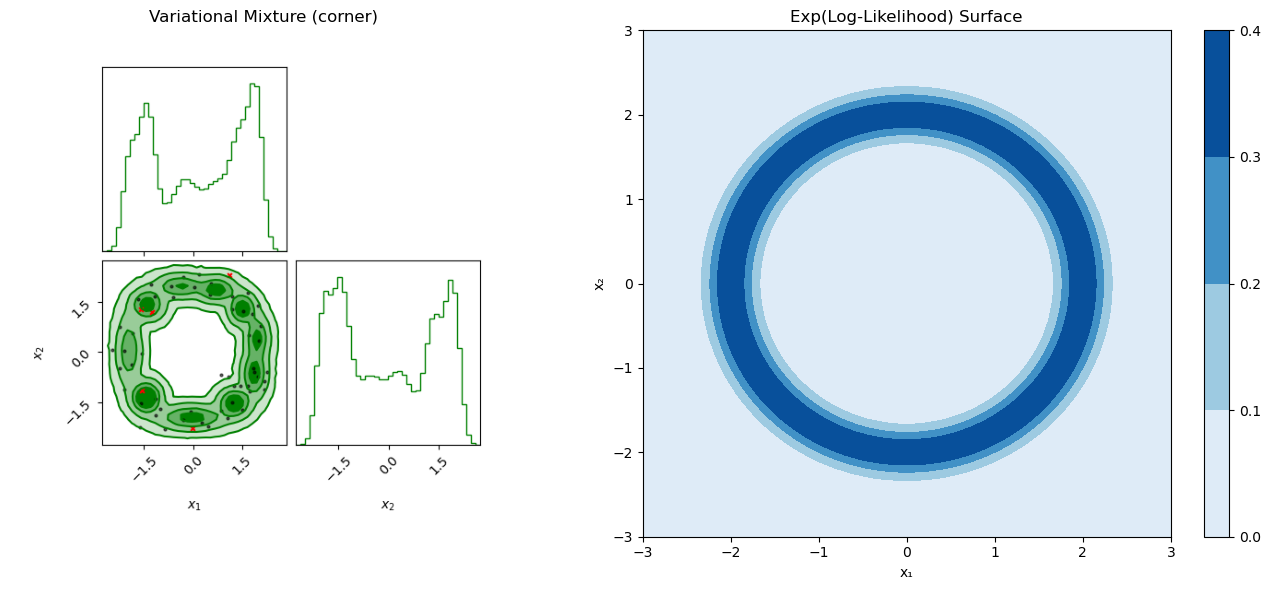

Adding new component.



100%|██████████| 80/80 [00:03<00:00, 24.24it/s]


Beggining Iter 13
Iter 13, 1250: ELBO = 0.7957, ELCBO = 0.7728
Iter 13, 2500: ELBO = 0.8040, ELCBO = 0.7825
Iter 13, 3750: ELBO = 0.8069, ELCBO = 0.7861
Iter 13, 5000: ELBO = 0.8055, ELCBO = 0.7849
Iter 13, 6250: ELBO = 0.8090, ELCBO = 0.7887
Iter 13, 7500: ELBO = 0.8080, ELCBO = 0.7876
Iter 13, 8750: ELBO = 0.8140, ELCBO = 0.7939
Iter 13, 10000: ELBO = 0.8151, ELCBO = 0.7950
Current Weights:
[0.09804692 0.09235026 0.07763295 0.11132928 0.08278766 0.07931005
 0.08821362 0.08314231 0.12622547 0.07972682 0.08123466]

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Plot After Iter 13 showing new training points



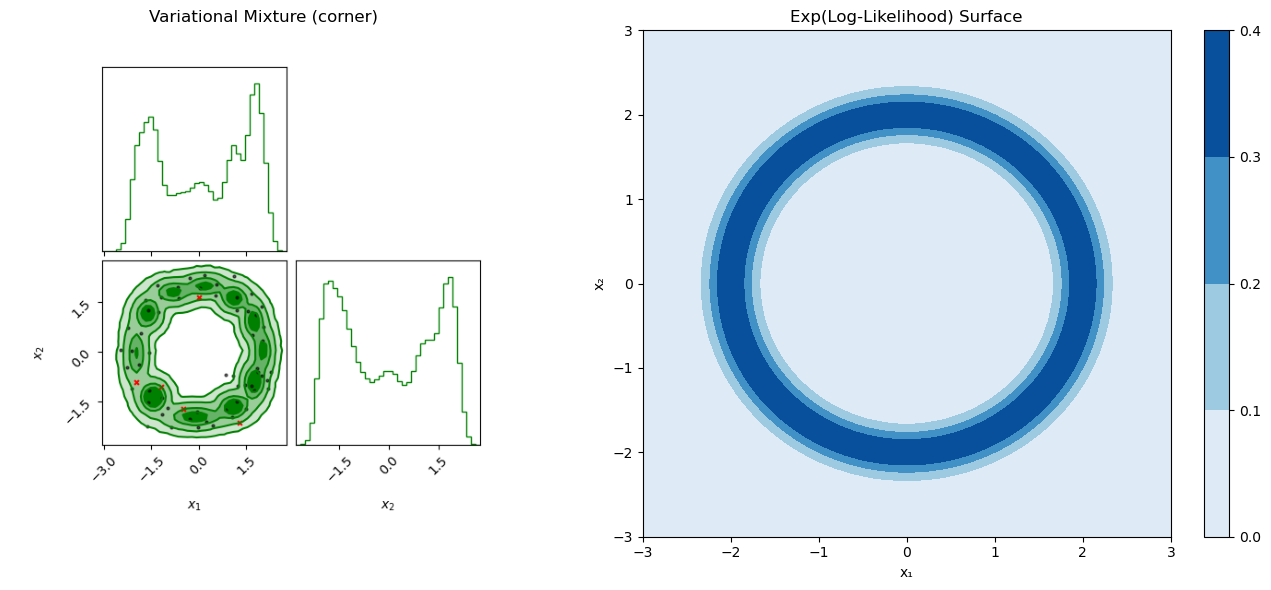

Adding new component.



100%|██████████| 80/80 [00:03<00:00, 23.02it/s]


Beggining Iter 14
Iter 14, 1250: ELBO = 0.8234, ELCBO = 0.8103
Iter 14, 2500: ELBO = 0.8266, ELCBO = 0.8138
Iter 14, 3750: ELBO = 0.8284, ELCBO = 0.8156
Iter 14, 5000: ELBO = 0.8288, ELCBO = 0.8163
Iter 14, 6250: ELBO = 0.8308, ELCBO = 0.8180
Iter 14, 7500: ELBO = 0.8306, ELCBO = 0.8178
Iter 14, 8750: ELBO = 0.8364, ELCBO = 0.8236
Iter 14, 10000: ELBO = 0.8320, ELCBO = 0.8193
Current Weights:
[0.09112238 0.08511717 0.07134646 0.10052736 0.07716597 0.07251996
 0.08081898 0.07582527 0.11542597 0.07403349 0.07442894 0.08166805]

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Plot After Iter 14 showing new training points



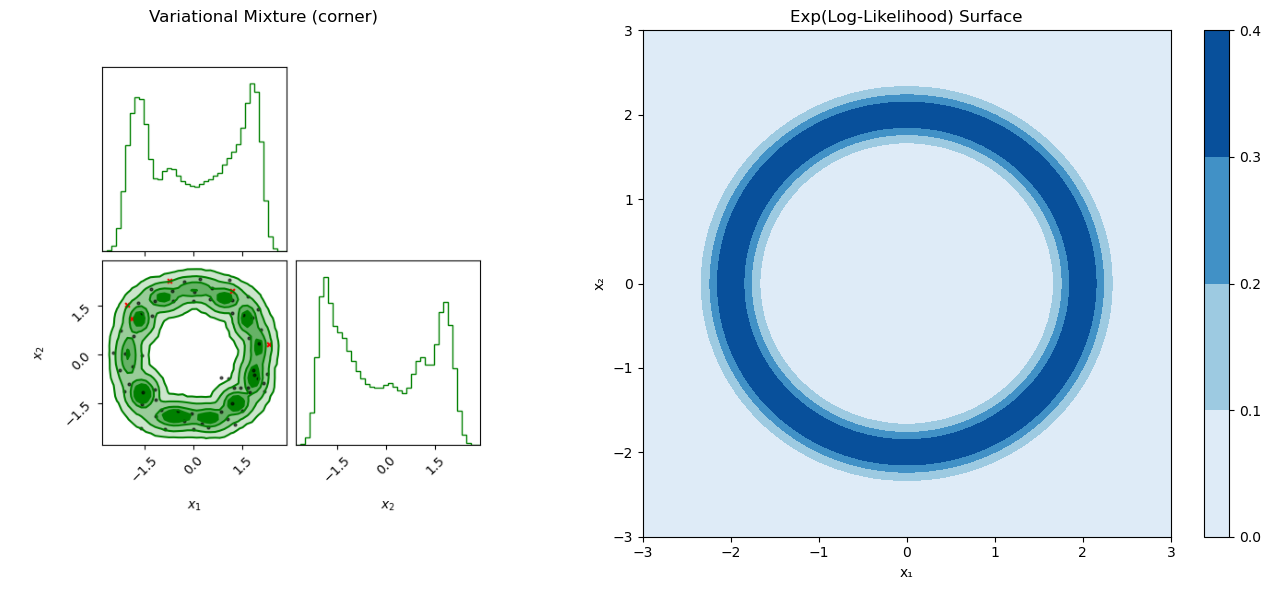

Adding new component.



100%|██████████| 80/80 [00:05<00:00, 14.88it/s]


Beggining Iter 15
Iter 15, 1250: ELBO = 0.8499, ELCBO = 0.8404
Iter 15, 2500: ELBO = 0.8476, ELCBO = 0.8381
Iter 15, 3750: ELBO = 0.8499, ELCBO = 0.8404
Iter 15, 5000: ELBO = 0.8536, ELCBO = 0.8441
Iter 15, 6250: ELBO = 0.8554, ELCBO = 0.8460
Iter 15, 7500: ELBO = 0.8497, ELCBO = 0.8403
Iter 15, 8750: ELBO = 0.8520, ELCBO = 0.8427
Iter 15, 10000: ELBO = 0.8541, ELCBO = 0.8448
Current Weights:
[0.08601509 0.07913729 0.06701529 0.09242915 0.07305956 0.06747624
 0.07509698 0.07050092 0.10677801 0.06962841 0.0696005  0.07685953
 0.06640301]

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Plot After Iter 15 showing new training points



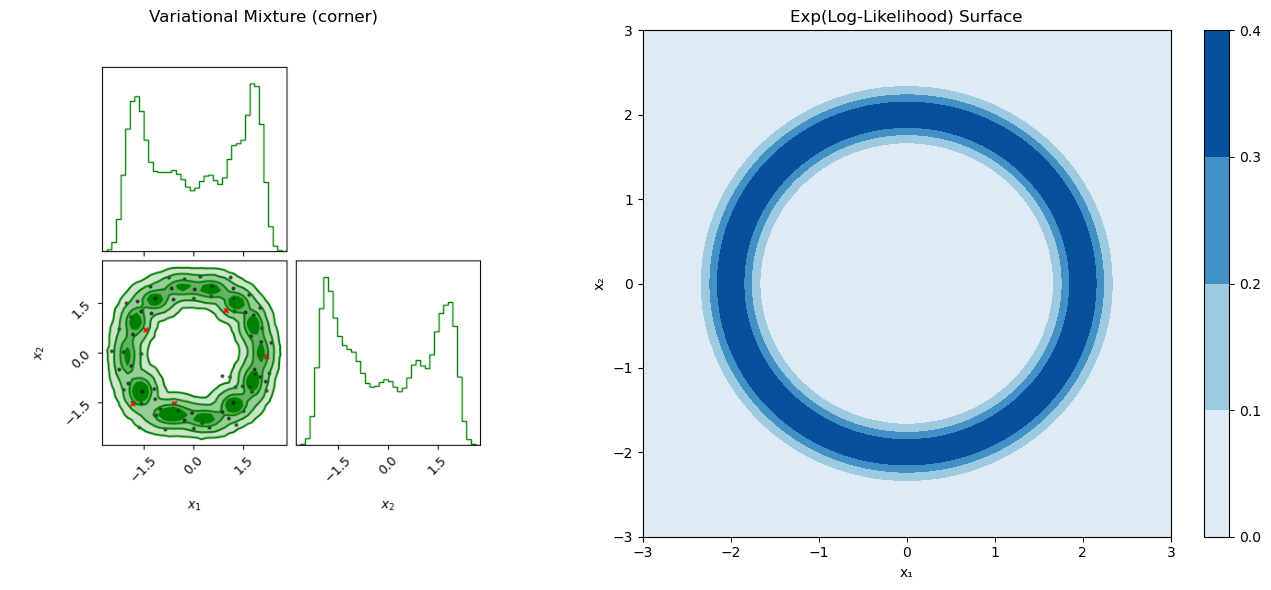

Adding new component.



100%|██████████| 80/80 [00:05<00:00, 14.42it/s]


Beggining Iter 16
Iter 16, 1250: ELBO = 0.8588, ELCBO = 0.8506
Iter 16, 2500: ELBO = 0.8632, ELCBO = 0.8550
Iter 16, 3750: ELBO = 0.8651, ELCBO = 0.8570
Iter 16, 5000: ELBO = 0.8650, ELCBO = 0.8568
Iter 16, 6250: ELBO = 0.8709, ELCBO = 0.8628
Iter 16, 7500: ELBO = 0.8645, ELCBO = 0.8564
Iter 16, 8750: ELBO = 0.8688, ELCBO = 0.8607
Iter 16, 10000: ELBO = 0.8689, ELCBO = 0.8607
Current Weights:
[0.08040231 0.0728828  0.06260139 0.08463258 0.06806732 0.06243958
 0.06965777 0.06503466 0.09765465 0.06487665 0.06439269 0.07202892
 0.06151596 0.07381272]

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Plot After Iter 16 showing new training points



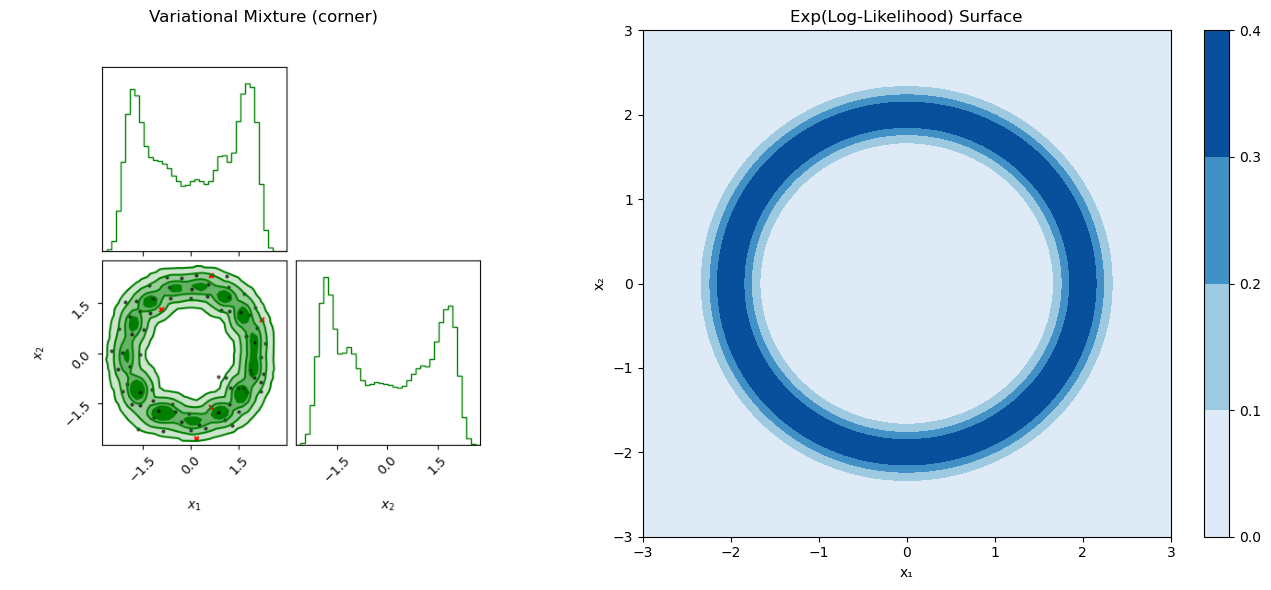

Adding new component.



100%|██████████| 80/80 [00:08<00:00,  9.45it/s]


Beggining Iter 17
Iter 17, 1250: ELBO = 0.8740, ELCBO = 0.8660
Iter 17, 2500: ELBO = 0.8773, ELCBO = 0.8694
Iter 17, 3750: ELBO = 0.8842, ELCBO = 0.8762
Iter 17, 5000: ELBO = 0.8809, ELCBO = 0.8729
Iter 17, 6250: ELBO = 0.8837, ELCBO = 0.8758
Iter 17, 7500: ELBO = 0.8805, ELCBO = 0.8725
Iter 17, 8750: ELBO = 0.8858, ELCBO = 0.8779
Iter 17, 10000: ELBO = 0.8853, ELCBO = 0.8774
Current Weights:
[0.07585209 0.06811613 0.05882231 0.07845991 0.0637574  0.05816174
 0.06506065 0.06059901 0.09008723 0.06079271 0.05996327 0.06783187
 0.05755928 0.06951285 0.06542358]

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Plot After Iter 17 showing new training points



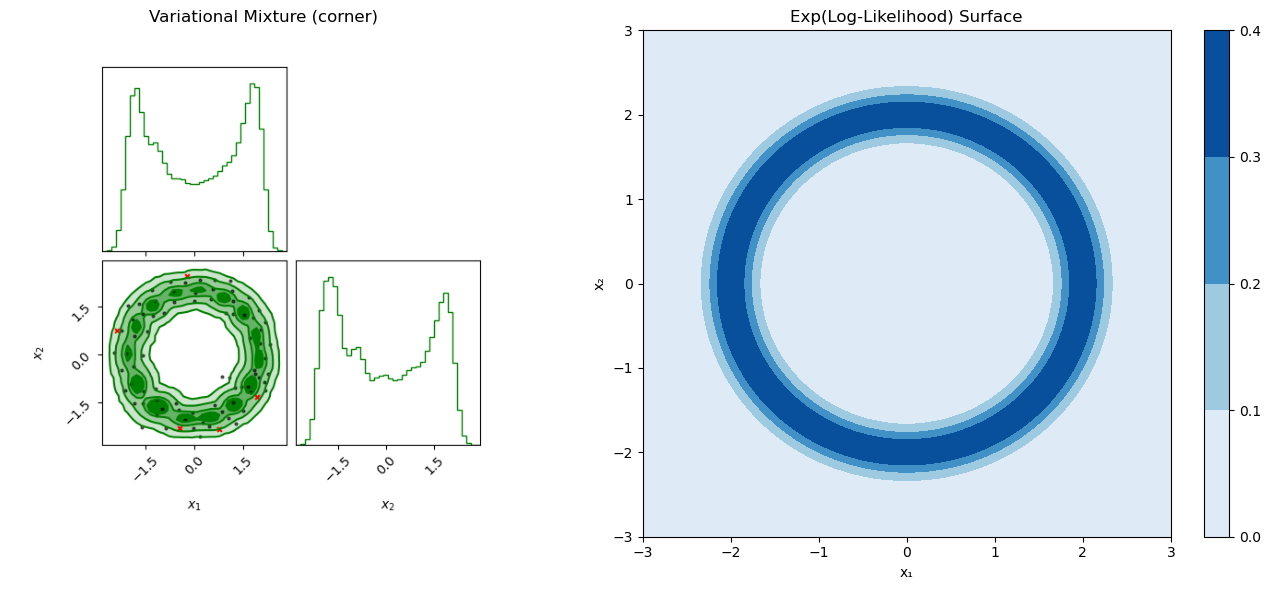

Adding new component.



100%|██████████| 80/80 [00:05<00:00, 13.48it/s]


Beggining Iter 18
Iter 18, 1250: ELBO = 0.8845, ELCBO = 0.8772
Iter 18, 2500: ELBO = 0.8865, ELCBO = 0.8791
Iter 18, 3750: ELBO = 0.8878, ELCBO = 0.8804
Iter 18, 5000: ELBO = 0.8904, ELCBO = 0.8831
Iter 18, 6250: ELBO = 0.8913, ELCBO = 0.8839
Iter 18, 7500: ELBO = 0.8923, ELCBO = 0.8849
Iter 18, 8750: ELBO = 0.8954, ELCBO = 0.8880
Iter 18, 10000: ELBO = 0.8904, ELCBO = 0.8831
Current Weights:
[0.07150039 0.06407593 0.05538145 0.07356385 0.05993272 0.05448852
 0.06088483 0.05678968 0.08338168 0.057145   0.0561382  0.06393713
 0.05405262 0.0656029  0.06147115 0.06165396]

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Plot After Iter 18 showing new training points



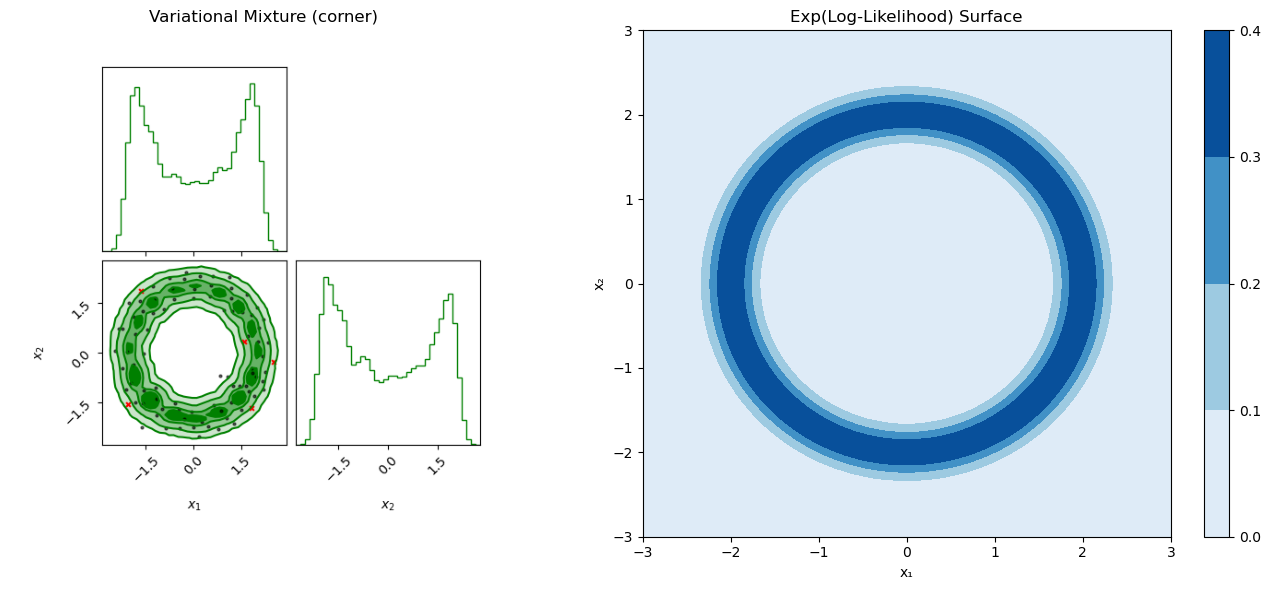

Adding new component.



100%|██████████| 80/80 [00:06<00:00, 13.01it/s]


Beggining Iter 19
Iter 19, 1250: ELBO = 0.8984, ELCBO = 0.8911
Iter 19, 2500: ELBO = 0.8985, ELCBO = 0.8913
Iter 19, 3750: ELBO = 0.8940, ELCBO = 0.8868
Iter 19, 5000: ELBO = 0.8948, ELCBO = 0.8876
Iter 19, 6250: ELBO = 0.9012, ELCBO = 0.8940
Iter 19, 7500: ELBO = 0.8944, ELCBO = 0.8872
Iter 19, 8750: ELBO = 0.8951, ELCBO = 0.8879
Iter 19, 10000: ELBO = 0.9009, ELCBO = 0.8937
Current Weights:
[0.0667387  0.05969804 0.05172132 0.06834603 0.05584837 0.05074669
 0.05653199 0.05280662 0.07697342 0.05326796 0.05220923 0.05977123
 0.05032294 0.06129585 0.05724911 0.0576789  0.06879359]

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Plot After Iter 19 showing new training points



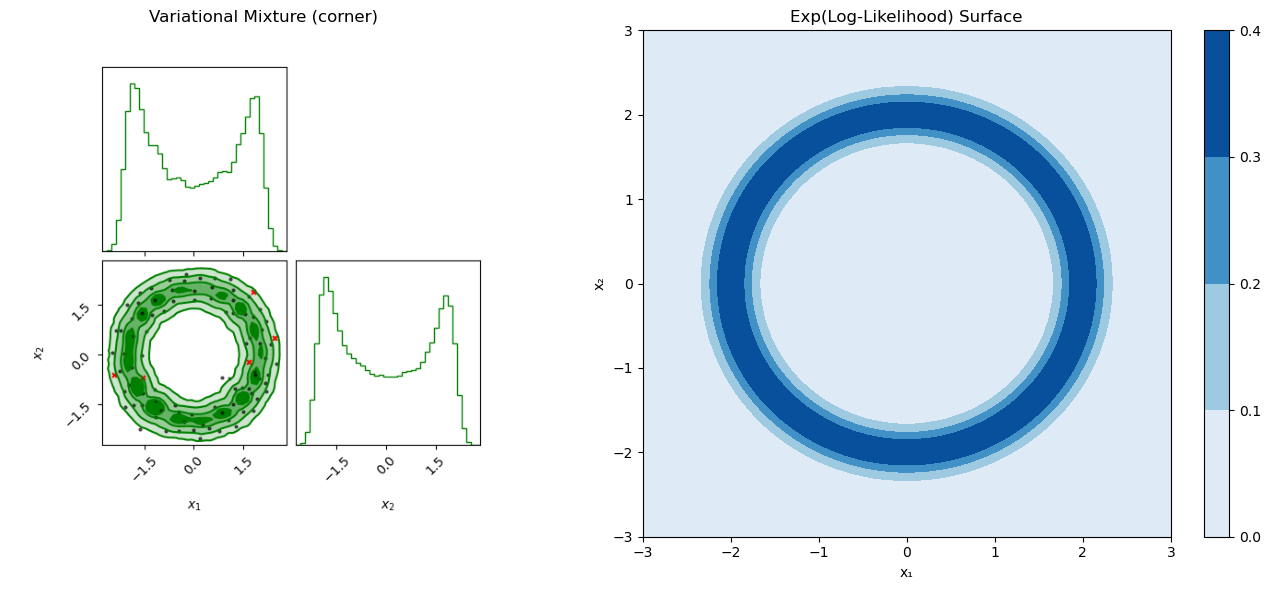

Adding new component.



100%|██████████| 80/80 [00:06<00:00, 12.10it/s]


Beggining Iter 20
Iter 20, 1250: ELBO = 0.8947, ELCBO = 0.8876
Iter 20, 2500: ELBO = 0.9043, ELCBO = 0.8973
Iter 20, 3750: ELBO = 0.9021, ELCBO = 0.8951
Iter 20, 5000: ELBO = 0.9079, ELCBO = 0.9009
Iter 20, 6250: ELBO = 0.9056, ELCBO = 0.8986
Iter 20, 7500: ELBO = 0.9089, ELCBO = 0.9019
Iter 20, 8750: ELBO = 0.8996, ELCBO = 0.8926
Iter 20, 10000: ELBO = 0.9041, ELCBO = 0.8971
Current Weights:
[0.0635313  0.05683654 0.04931392 0.06477671 0.05333912 0.04833303
 0.0536677  0.05027716 0.07262618 0.05086241 0.04963004 0.05705509
 0.04787141 0.05844224 0.05455581 0.05518702 0.06569004 0.0480043 ]

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Plot After Iter 20 showing new training points



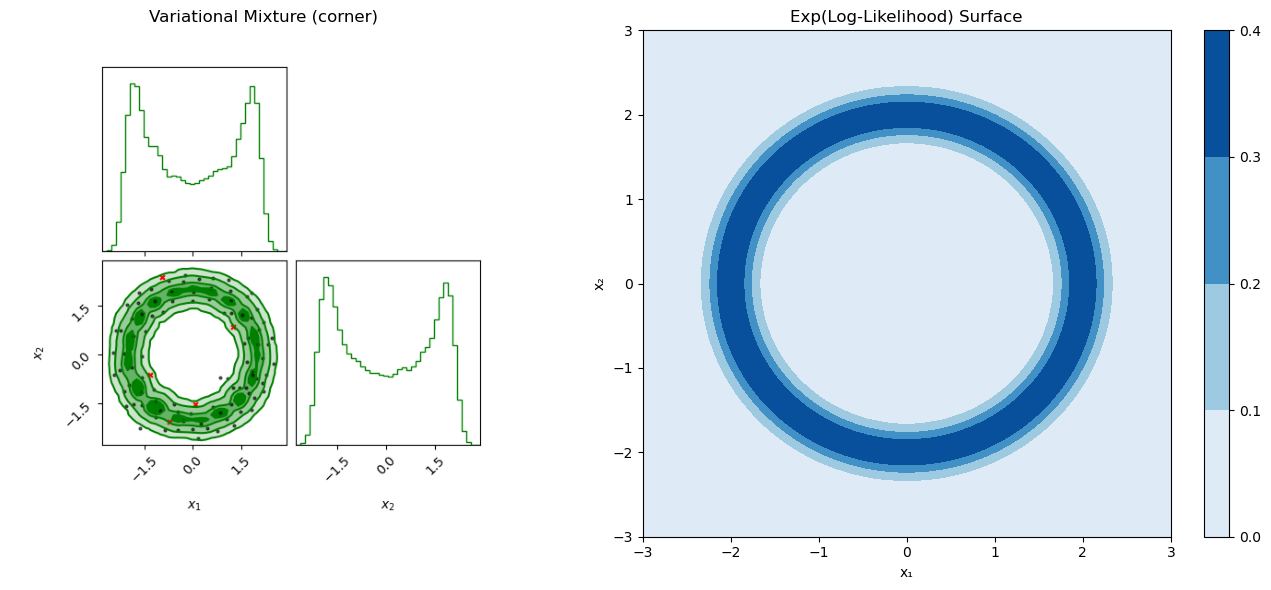

Adding new component.



100%|██████████| 80/80 [00:07<00:00, 11.06it/s]


Beggining Iter 21
Iter 21, 1250: ELBO = 0.9005, ELCBO = 0.8935
Iter 21, 2500: ELBO = 0.9058, ELCBO = 0.8988
Iter 21, 3750: ELBO = 0.9037, ELCBO = 0.8967
Iter 21, 5000: ELBO = 0.9051, ELCBO = 0.8981
Iter 21, 6250: ELBO = 0.9075, ELCBO = 0.9005
Iter 21, 7500: ELBO = 0.9092, ELCBO = 0.9022
Iter 21, 8750: ELBO = 0.9054, ELCBO = 0.8984
Iter 21, 10000: ELBO = 0.9049, ELCBO = 0.8980


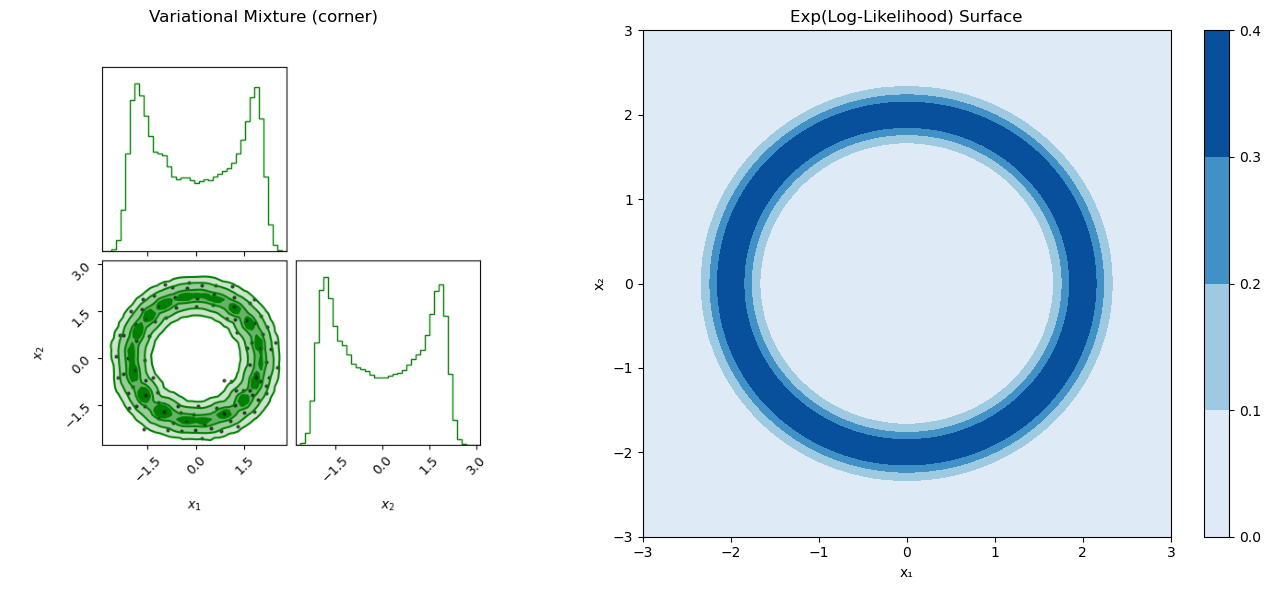

In [ ]:

grad_elbo = jit(
    grad(lambda *args, **kwargs: elbo(*args, **kwargs)[0]),
    static_argnames=['fullsig']
)


seed = int(time.time()*1e6)
key = jax.random.PRNGKey(seed)

# current bounds
PLB = jnp.array([-3, -3])
PUB = jnp.array([3, 3])
range_ = PUB - PLB
extension = 0.35*range_
lower = PLB - extension
upper = PUB + extension



params, elbo_history, elcbo_history = vbmc(
    grad_elbo, d=2, PLB=PLB, PUB=PUB, lower=lower, upper=upper, n_initial=8,
    alpha=1.5, beta=0.5, gamma=1,
    lr=0.001, k=2, n_points=6,
    rsp=5, n1=21, n2=10_000, 
    plots=True, ll=expensive_log_likelihood, 
    params_true=params_true,
    key=key,fullsig=True)


This example uses a pseudo likelihood, not necessarily integrating to 1 for each parameter value. This means that the ELBO
$$
\mathcal{L}(q) = \mathbb{E}_{q(\theta)}[\log p_{\text{pseudo}}(y \mid \theta)] - \mathrm{KL}(q(\theta)\|p(\theta))
$$
is no longer a true lower bound on the log-evidence. It still acts as a practical surrogate objective for VBMC, guiding $q(\theta)$ toward regions of high pseudo-likelihood, though its absolute value has no strict probabilistic meaning.


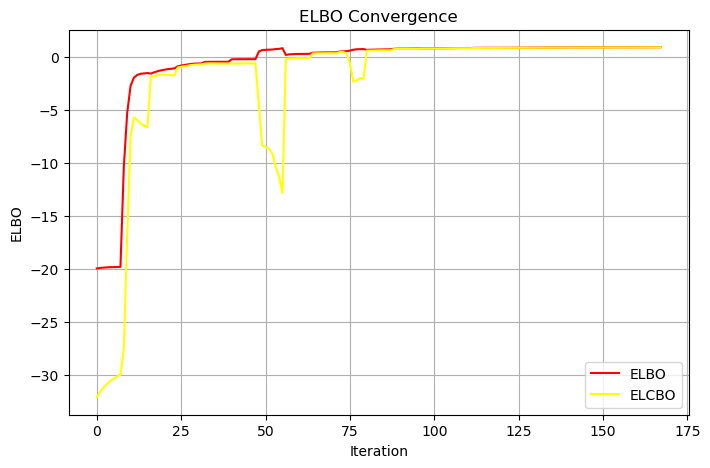

In [11]:
# Plot ELBO history
plt.figure(figsize=(8,5))
plt.plot(elbo_history, label='ELBO', color='red')
plt.plot(elcbo_history, label='ELCBO', color='yellow')
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.title("ELBO Convergence")
plt.legend()
plt.show()


#### Corner plot comparison

True Distribution


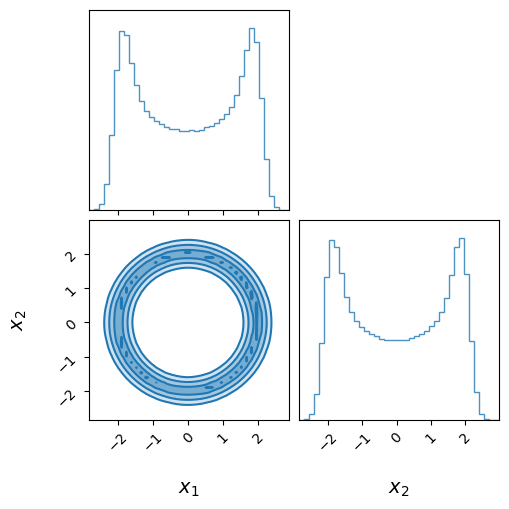

Variational Mixture


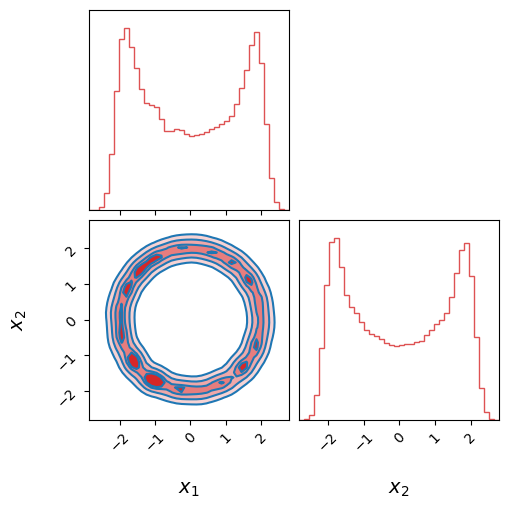

In [12]:
def true_likelihood(xy):
    return jnp.exp(expensive_log_likelihood(xy, params_true))

# Accept Reject sampling
n_samples = 1_000_000
samples = []
x_min, x_max = -3.5, 3.5
y_min, y_max = -3.0, 3.0

while len(samples) < n_samples:
    xy = np.random.uniform([x_min, y_min], [x_max, y_max], size=(n_samples, 2))
    probs = true_likelihood(xy)
    u = np.random.uniform(0, 1, size=n_samples)
    accepted = xy[u < probs]
    samples.extend(accepted.tolist())
    samples = samples[:n_samples]

samples1 = np.array(samples)


means = params[0]
vars_ = jnp.exp(params[1])
weights = params[2]
weights = jnp.exp(weights)/jnp.sum(jnp.exp(weights))

dim = means.shape[1]

components = np.random.choice(len(weights), size=n_samples, p=weights)
samples2 = np.zeros((n_samples, dim))
for i in range(len(weights)):
    mask = (components == i)
    n_i = np.sum(mask)
    if n_i > 0:
        samples2[mask] = np.random.normal(loc=means[i], scale=np.sqrt(vars_[i]), size=(n_i, dim))


import corner
import matplotlib.pyplot as plt

# Shared styling for contour-only plots
base_kwargs = dict(
    bins=40,
    smooth=1.2,
    plot_datapoints=False,     # remove all the dots
    plot_density=True,         # still shade density
    plot_contours=True,        # show contours
    fill_contours=True,        # fill contour levels
    contour_kwargs={"linewidths": 1.5},
    label_kwargs={"fontsize": 14},
    show_titles=False,         # no mean/σ text
    max_n_ticks=6,
)

# True Distribution
print("True Distribution")
corner_kwargs = base_kwargs.copy()
corner_kwargs.update({
    "color": "#1f77b4",
    "hist_kwargs": {"alpha": 0.8},  # only filled contour colours
})
figure = corner.corner(samples1, labels=[r"$x_1$", r"$x_2$"], **corner_kwargs)
plt.show()

# Variational Mixture
print("Variational Mixture")
corner_kwargs = base_kwargs.copy()
corner_kwargs.update({
    "color": "#d62728",
    "hist_kwargs": {"alpha": 0.8},
})
figure = corner.corner(samples2, labels=[r"$x_1$", r"$x_2$"], **corner_kwargs)
plt.show()



#### Full plot comparison

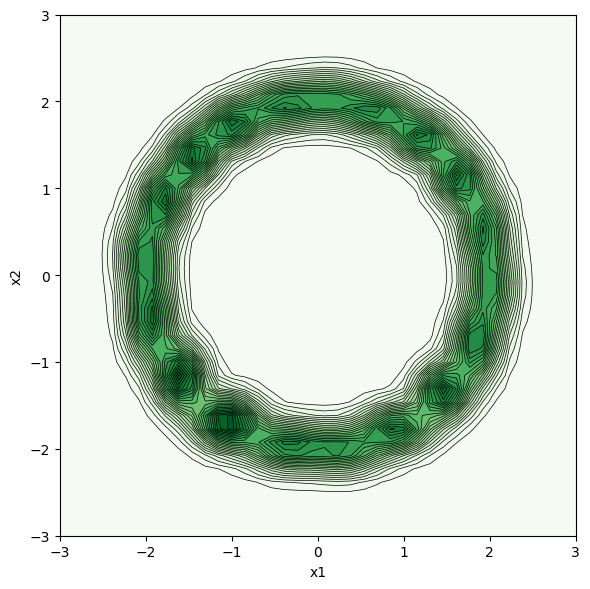

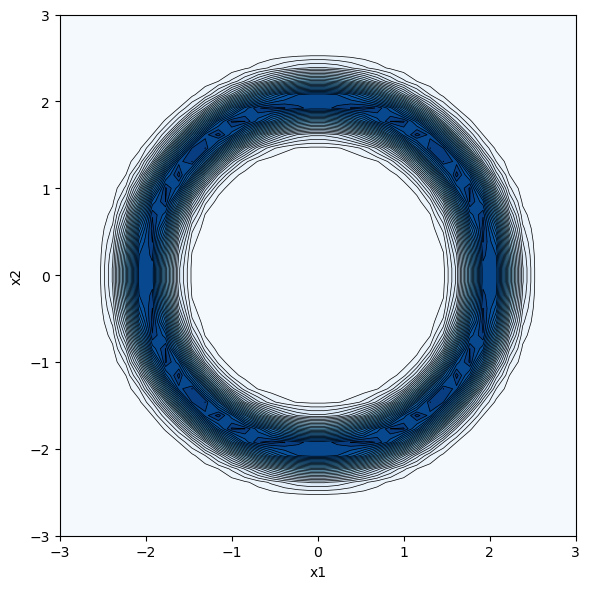

In [13]:
ll = expensive_log_likelihood
mu = params[0]
d = params[0].shape[1]
sigma = jnp.array([jnp.ones(d) * jnp.exp(s) for s in params[1]])
logitweights = params[2]
weights = jax.nn.softmax(logitweights)

# grid for evaluation
lower1, upper1 = -3, 3
lower2, upper2 = -3, 3
x1_eval = jnp.linspace(lower1, upper1, 40)
x2_eval = jnp.linspace(lower2, upper2, 40)
X1_eval, X2_eval = jnp.meshgrid(x1_eval, x2_eval)
points = jnp.column_stack([X1_eval.ravel(), X2_eval.ravel()])

# --- Plot 1: Variational Mixture PDF ---
plt.figure(figsize=(6, 6))
mixture_vals = jax.vmap(lambda x: mixture_pdf(x, mu, sigma, weights))(points)
mixture_grid = mixture_vals.reshape(X1_eval.shape)

plt.contourf(X1_eval, X2_eval, mixture_grid, levels=25, cmap='Greens')
plt.contour(X1_eval, X2_eval, mixture_grid, levels=25, colors="black", linewidths=0.5)
#plt.scatter(mu[:, 0], mu[:, 1], marker='x', color='red', s=40, linewidths=1.2, label='Component Means')
plt.xlabel("x1")
plt.ylabel("x2")
plt.tight_layout()
plt.show()

# --- Plot 2: True Distribution ---
plt.figure(figsize=(6, 6))
ll_vals = ll(points, params_true).ravel()
mixture_true = jnp.exp(ll_vals).reshape(X1_eval.shape)

plt.contourf(X1_eval, X2_eval, mixture_true, levels=30, cmap='Blues')
plt.contour(X1_eval, X2_eval, mixture_true, levels=30, colors='black', linewidths=0.5)
plt.xlabel("x1")
plt.ylabel("x2")
plt.tight_layout()
plt.show()




### 4D Gaussian Mixture Example

Let the true component means and covariances be given by

$$
\mu_{\text{true}} =
\begin{bmatrix}
3.0 & -1.5 & 0.0 & 2.0 \\
-2.0 & 2.5 & -3.0 & 1.0 \\
1.5 & 0.5 & 2.5 & -2.0 \\
0.0 & -3.5 & 3.5 & 0.5
\end{bmatrix},
\qquad
\Sigma_{\text{true}} =
\begin{bmatrix}
\Sigma_1 \\
\Sigma_2 \\
\Sigma_3 \\
\Sigma_4
\end{bmatrix},
$$

where each $\Sigma_k \in \mathbb{R}^{4 \times 4}$ denotes the covariance matrix of component $k$.

The overall mixture density can be expressed as

$$
p(\mathbf{x}) = \sum_{k=1}^{4} \pi_k \,
\mathcal{N}\big(\mathbf{x} \mid \mu_k, \Sigma_k\big),
\quad \mathbf{x} \in \mathbb{R}^4,
$$

where $\pi_k$ are the mixture weights satisfying $\sum_k \pi_k = 1$.



In [11]:
def expensive_log_likelihood(obs, params):
    mu_params, s_params, weights = params
    n_components = mu_params.shape[0]

    if s_params.ndim == 2:  
        s_params = jnp.array([jnp.diag(s) for s in s_params])
        
    # equal weights if none
    if weights is None:
        weights = jnp.ones(n_components)/n_components
    else:
        weights = jnp.array(weights)/jnp.sum(weights)

    terms = jnp.stack([comp_pdf(obs, mu_params[i], s_params[i]) for i in range(n_components)], axis=1)
    likelihood = jnp.sum(weights*terms, axis=1)
    log_likelihood = jnp.log(likelihood + 1e-12)
    return log_likelihood
    
mu_true = jnp.array([
    [3.0, -1.5, 0.0, 2.0],
    [-2.0, 2.5, -3.0, 1.0],
    [1.5, 0.5, 2.5, -2.0],
    [0.0, -3.5, 3.5, 0.5]
])

s_true = jnp.array([
    [[1.5, 0.8, 0.3, 0.2],
     [0.8, 2.0, 0.4, -0.1],
     [0.3, 0.4, 1.8, 0.5],
     [0.2, -0.1, 0.5, 1.2]],
    
    [[2.0, -1.0, 0.2, 0.4],
     [-1.0, 2.5, 0.3, -0.2],
     [0.2, 0.3, 1.5, 0.0],
     [0.4, -0.2, 0.0, 1.3]],
    
    [[1.2, 0.4, 0.5, 0.3],
     [0.4, 1.8, 0.6, 0.0],
     [0.5, 0.6, 2.0, 0.5],
     [0.3, 0.0, 0.5, 1.5]],
    
    [[1.6, -0.2, 0.4, 0.7],
     [-0.2, 1.4, -0.3, 0.2],
     [0.4, -0.3, 2.2, -0.1],
     [0.7, 0.2, -0.1, 1.8]]
])

weights_true = jnp.array([0.35, 0.2, 0.15, 0.3])

params_true = (mu_true, s_true, weights_true)

Beginning Warmup Phase

Sampling first 8 points and Initialising Mixture



100%|██████████| 1500/1500 [01:01<00:00, 24.28it/s]


Plot Before Iter 1



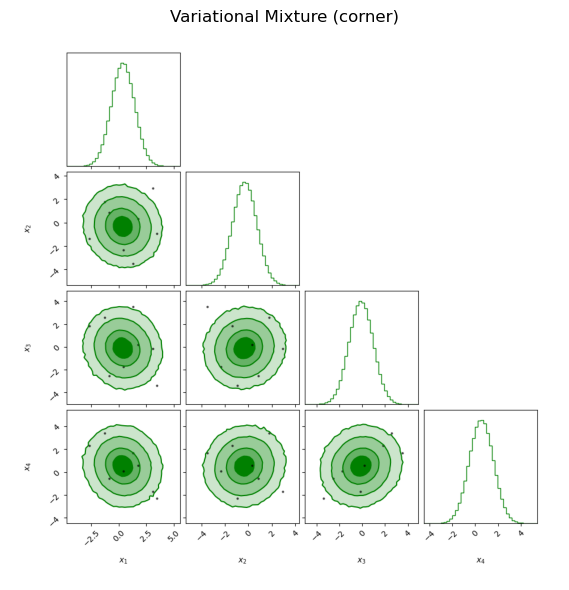

Beggining Iter 1
Jittered Candidate Selected
Iter 1, 1250: ELBO = -1.9297, ELCBO = -6.1925
Iter 1, 2500: ELBO = -1.5678, ELCBO = -5.9123
Iter 1, 3750: ELBO = -1.2633, ELCBO = -5.6962
Iter 1, 5000: ELBO = -0.9952, ELCBO = -5.5158
Iter 1, 6250: ELBO = -0.7645, ELCBO = -5.3702
Iter 1, 7500: ELBO = -0.5758, ELCBO = -5.2618
Iter 1, 8750: ELBO = -0.4259, ELCBO = -5.1878
Iter 1, 10000: ELBO = -0.3062, ELCBO = -5.1379

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Plot After Iter 1 showing new training points



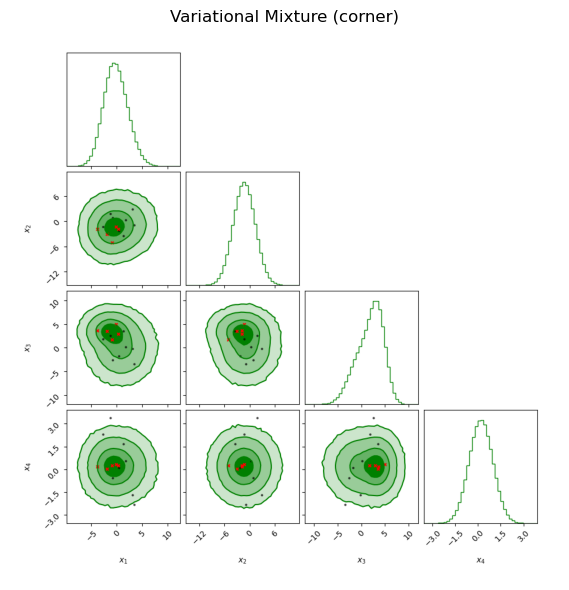

  0%|          | 0/800 [00:00<?, ?it/s]c:\Users\gmedw\miniconda3\envs\pgmpy_env\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 800/800 [00:33<00:00, 23.82it/s]


Beggining Iter 2
Iter 2, 1250: ELBO = -1.0487, ELCBO = -3.9963
Iter 2, 2500: ELBO = -0.9414, ELCBO = -3.9811
Iter 2, 3750: ELBO = -0.8607, ELCBO = -3.9823
Iter 2, 5000: ELBO = -0.7788, ELCBO = -3.9733
Iter 2, 6250: ELBO = -0.7023, ELCBO = -3.9617
Iter 2, 7500: ELBO = -0.6380, ELCBO = -3.9567
Iter 2, 8750: ELBO = -0.5722, ELCBO = -3.9469
Iter 2, 10000: ELBO = -0.5215, ELCBO = -3.9517

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Plot After Iter 2 showing new training points



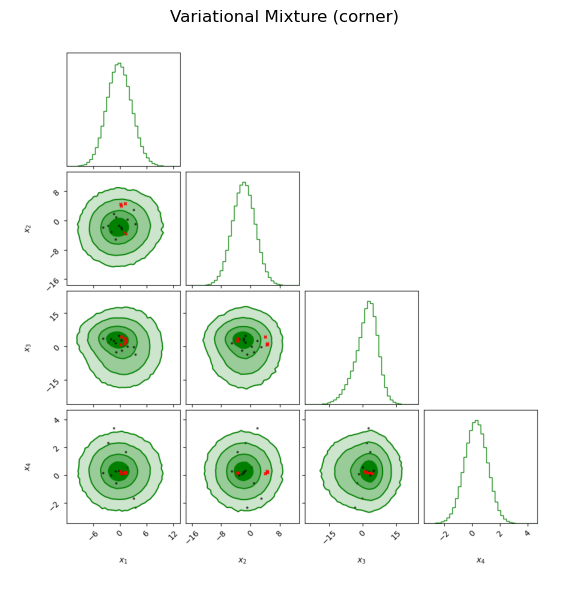

100%|██████████| 800/800 [00:47<00:00, 16.75it/s]


Beggining Iter 3
Iter 3, 1250: ELBO = -1.5281, ELCBO = -5.2264
Iter 3, 2500: ELBO = -1.3778, ELCBO = -4.4151
Iter 3, 3750: ELBO = -1.2934, ELCBO = -3.9893
Iter 3, 5000: ELBO = -1.2393, ELCBO = -3.7353
Iter 3, 6250: ELBO = -1.2030, ELCBO = -3.5740
Iter 3, 7500: ELBO = -1.1631, ELCBO = -3.4526
Iter 3, 8750: ELBO = -1.1434, ELCBO = -3.3773
Iter 3, 10000: ELBO = -1.1283, ELCBO = -3.3224

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Plot After Iter 3 showing new training points



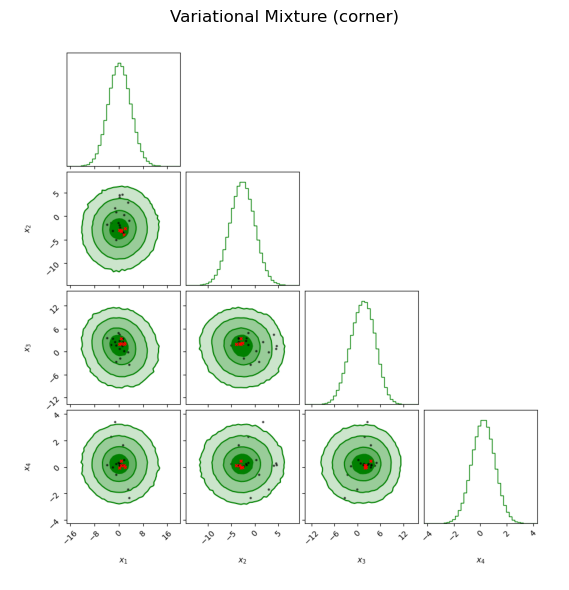

100%|██████████| 800/800 [00:48<00:00, 16.60it/s]


Beggining Iter 4
Iter 4, 1250: ELBO = -1.3534, ELCBO = -4.7825
Iter 4, 2500: ELBO = -1.2802, ELCBO = -4.3026
Iter 4, 3750: ELBO = -1.2213, ELCBO = -3.9792
Iter 4, 5000: ELBO = -1.1849, ELCBO = -3.7631
Iter 4, 6250: ELBO = -1.1548, ELCBO = -3.6053
Iter 4, 7500: ELBO = -1.1309, ELCBO = -3.4902
Iter 4, 8750: ELBO = -1.1069, ELCBO = -3.3993
Iter 4, 10000: ELBO = -1.0988, ELCBO = -3.3422

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Plot After Iter 4 showing new training points



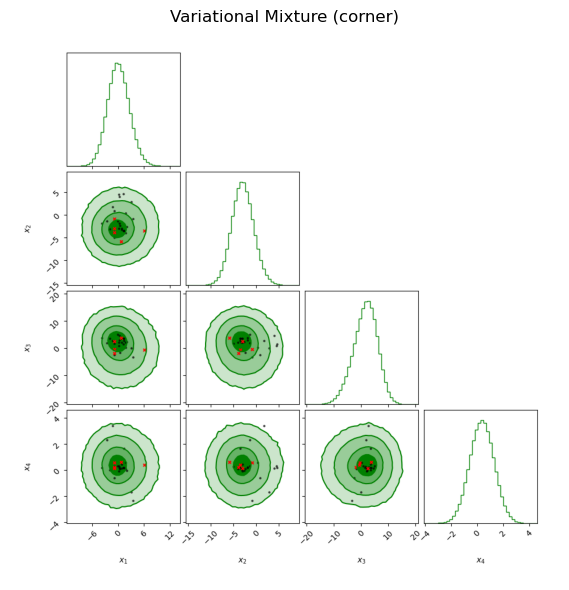

100%|██████████| 800/800 [00:51<00:00, 15.58it/s]


Beggining Iter 5
Iter 5, 1250: ELBO = -1.8475, ELCBO = -3.4119
Iter 5, 2500: ELBO = -1.6665, ELCBO = -3.0801
Iter 5, 3750: ELBO = -1.5363, ELCBO = -2.8496
Iter 5, 5000: ELBO = -1.4274, ELCBO = -2.6726
Iter 5, 6250: ELBO = -1.3470, ELCBO = -2.5476
Iter 5, 7500: ELBO = -1.2923, ELCBO = -2.4649
Iter 5, 8750: ELBO = -1.2547, ELCBO = -2.4093
Iter 5, 10000: ELBO = -1.2218, ELCBO = -2.3653

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Plot After Iter 5 showing new training points



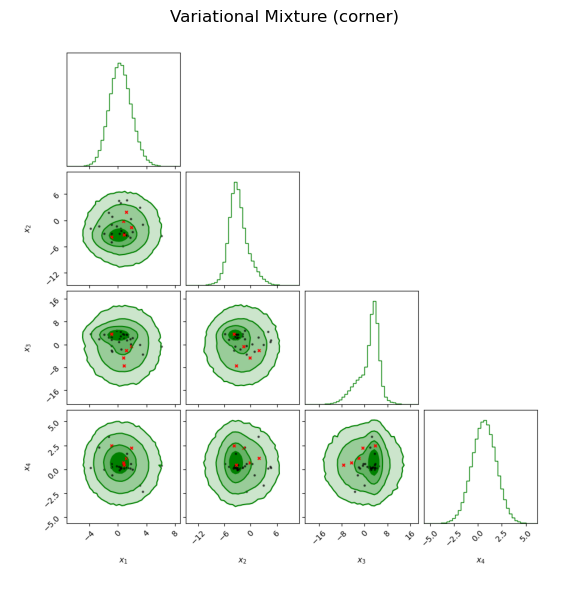

100%|██████████| 800/800 [00:59<00:00, 13.33it/s]


Beggining Iter 6
Iter 6, 1250: ELBO = -1.3699, ELCBO = -2.4147
Iter 6, 2500: ELBO = -1.2919, ELCBO = -2.2639
Iter 6, 3750: ELBO = -1.2357, ELCBO = -2.1754
Iter 6, 5000: ELBO = -1.2086, ELCBO = -2.1357
Iter 6, 6250: ELBO = -1.1854, ELCBO = -2.1090
Iter 6, 7500: ELBO = -1.1751, ELCBO = -2.0991
Iter 6, 8750: ELBO = -1.1654, ELCBO = -2.0905
Iter 6, 10000: ELBO = -1.1496, ELCBO = -2.0762

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Plot After Iter 6 showing new training points



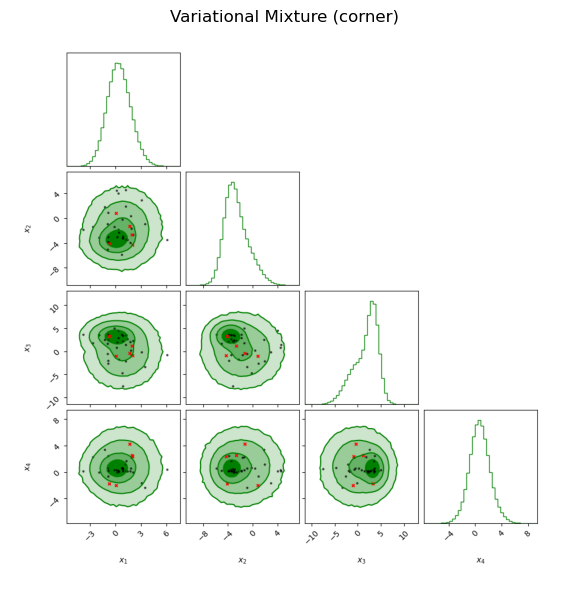

  0%|          | 0/800 [00:00<?, ?it/s]c:\Users\gmedw\miniconda3\envs\pgmpy_env\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 800/800 [00:50<00:00, 16.00it/s]


Beggining Iter 7
Iter 7, 1250: ELBO = -1.2095, ELCBO = -1.8063
Iter 7, 2500: ELBO = -1.1812, ELCBO = -1.7610
Iter 7, 3750: ELBO = -1.1538, ELCBO = -1.7257
Iter 7, 5000: ELBO = -1.1331, ELCBO = -1.7012
Iter 7, 6250: ELBO = -1.1097, ELCBO = -1.6762
Iter 7, 7500: ELBO = -1.0890, ELCBO = -1.6545
Iter 7, 8750: ELBO = -1.0679, ELCBO = -1.6331
Iter 7, 10000: ELBO = -1.0615, ELCBO = -1.6267
Improvement is positive and less than 1.5 for three consecutive iterations

Warm up phase complete:

Adding new component.
Plot After Iter 7 showing new training points



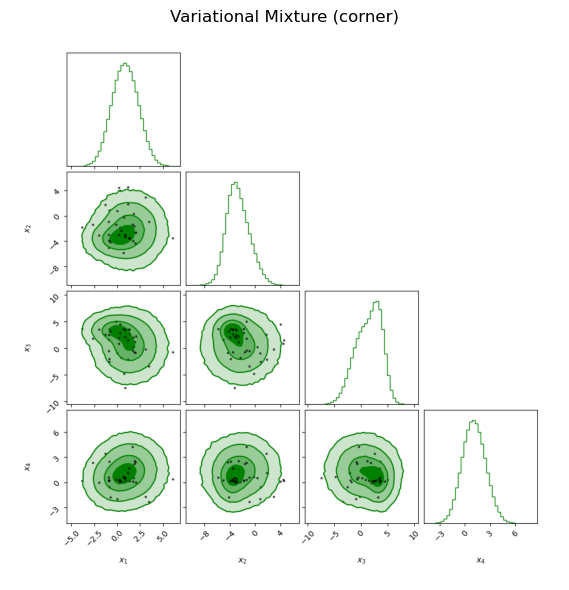

100%|██████████| 400/400 [00:25<00:00, 15.86it/s]


Beggining Iter 8
Iter 8, 1250: ELBO = -1.0977, ELCBO = -1.5606
Iter 8, 2500: ELBO = -1.0499, ELCBO = -1.4859
Iter 8, 3750: ELBO = -1.0324, ELCBO = -1.4455
Iter 8, 5000: ELBO = -1.0169, ELCBO = -1.4228
Iter 8, 6250: ELBO = -1.0062, ELCBO = -1.4143
Iter 8, 7500: ELBO = -0.9888, ELCBO = -1.4037
Iter 8, 8750: ELBO = -0.9816, ELCBO = -1.4027
Iter 8, 10000: ELBO = -0.9749, ELCBO = -1.4002

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Adding new component.
Plot After Iter 8 showing new training points



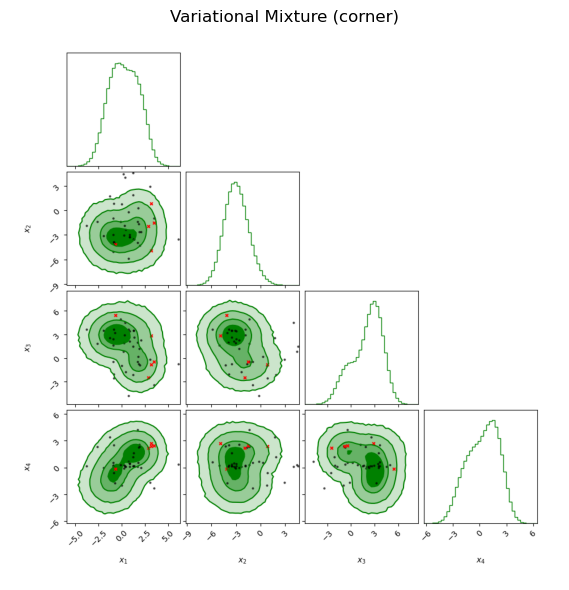

  0%|          | 0/320 [00:00<?, ?it/s]c:\Users\gmedw\miniconda3\envs\pgmpy_env\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 320/320 [00:39<00:00,  8.14it/s]


Beggining Iter 9
Jittered Candidate Selected
Iter 9, 1250: ELBO = -0.8240, ELCBO = -1.1122
Iter 9, 2500: ELBO = -0.8158, ELCBO = -1.0940
Iter 9, 3750: ELBO = -0.8059, ELCBO = -1.0782
Iter 9, 5000: ELBO = -0.7832, ELCBO = -1.0527
Iter 9, 6250: ELBO = -0.7833, ELCBO = -1.0533
Iter 9, 7500: ELBO = -0.7805, ELCBO = -1.0551
Iter 9, 8750: ELBO = -0.7674, ELCBO = -1.0456
Iter 9, 10000: ELBO = -0.7804, ELCBO = -1.0620

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Adding new component.
Plot After Iter 9 showing new training points



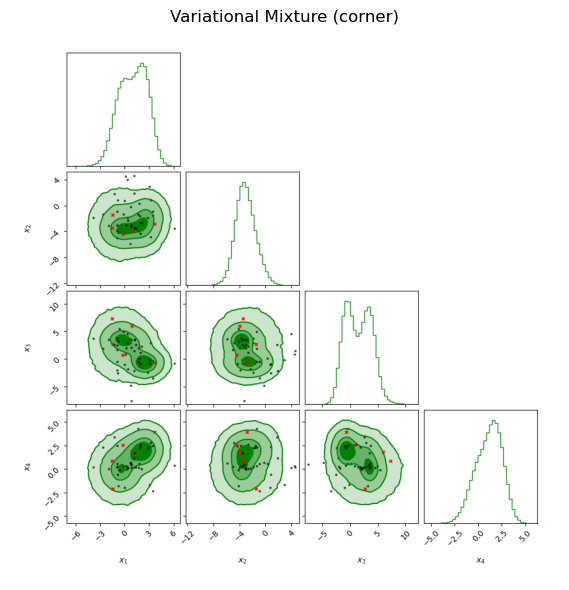

100%|██████████| 320/320 [00:22<00:00, 14.13it/s]


Beggining Iter 10
Iter 10, 1250: ELBO = -0.7058, ELCBO = -1.0702
Iter 10, 2500: ELBO = -0.6933, ELCBO = -1.0830
Iter 10, 3750: ELBO = -0.6794, ELCBO = -1.0817
Iter 10, 5000: ELBO = -0.6799, ELCBO = -1.0925
Iter 10, 6250: ELBO = -0.6766, ELCBO = -1.0956
Iter 10, 7500: ELBO = -0.6656, ELCBO = -1.0905
Iter 10, 8750: ELBO = -0.6654, ELCBO = -1.0962
Iter 10, 10000: ELBO = -0.6710, ELCBO = -1.1069

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Adding new component.
Plot After Iter 10 showing new training points



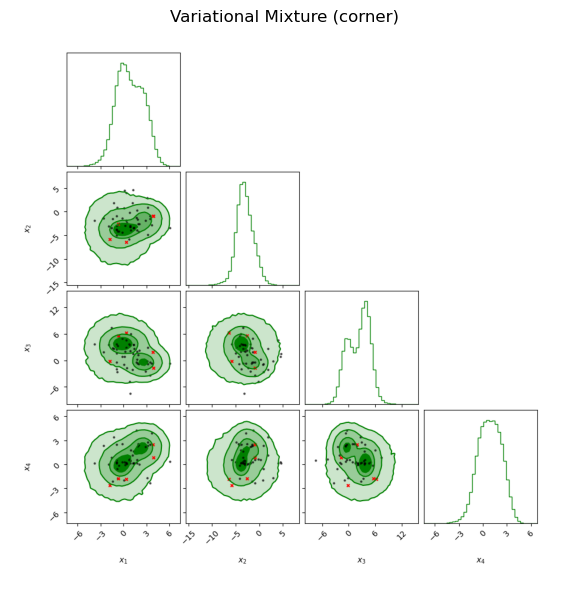

100%|██████████| 320/320 [00:20<00:00, 15.95it/s]


Beggining Iter 11
Iter 11, 1250: ELBO = -0.6271, ELCBO = -0.8448
Iter 11, 2500: ELBO = -0.6038, ELCBO = -0.8200
Iter 11, 3750: ELBO = -0.5818, ELCBO = -0.8004
Iter 11, 5000: ELBO = -0.5800, ELCBO = -0.8008
Iter 11, 6250: ELBO = -0.5800, ELCBO = -0.8011
Iter 11, 7500: ELBO = -0.5777, ELCBO = -0.7990
Iter 11, 8750: ELBO = -0.5656, ELCBO = -0.7889
Iter 11, 10000: ELBO = -0.5680, ELCBO = -0.7902

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Adding new component.
Plot After Iter 11 showing new training points



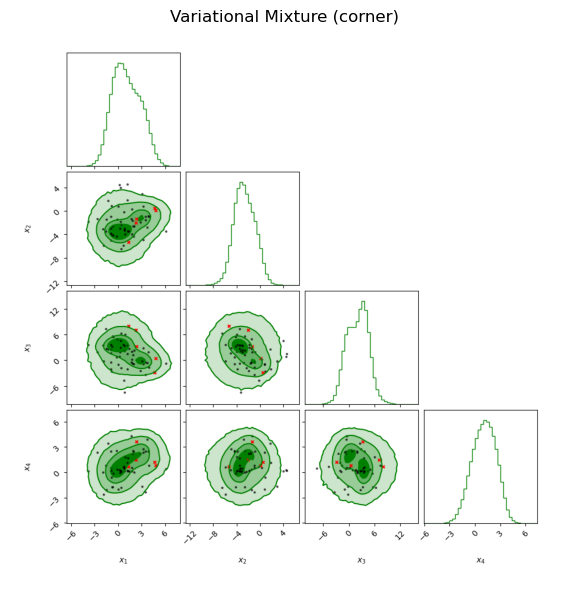

  0%|          | 0/240 [00:00<?, ?it/s]c:\Users\gmedw\miniconda3\envs\pgmpy_env\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 240/240 [00:16<00:00, 14.65it/s]


Weights now free to move
Beggining Iter 12
Iter 12, 1250: ELBO = -0.5818, ELCBO = -0.7791
Iter 12, 2500: ELBO = -0.5785, ELCBO = -0.7820
Iter 12, 3750: ELBO = -0.5860, ELCBO = -0.7891
Iter 12, 5000: ELBO = -0.5718, ELCBO = -0.7749
Iter 12, 6250: ELBO = -0.5679, ELCBO = -0.7706
Iter 12, 7500: ELBO = -0.5522, ELCBO = -0.7551
Iter 12, 8750: ELBO = -0.5538, ELCBO = -0.7531
Iter 12, 10000: ELBO = -0.5220, ELCBO = -0.7046
Current Weights:
[0.14961261 0.16089346 0.13900436 0.1299044  0.159189   0.1635153
 0.09788087]

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Adding new component.
Plot After Iter 12 showing new training points



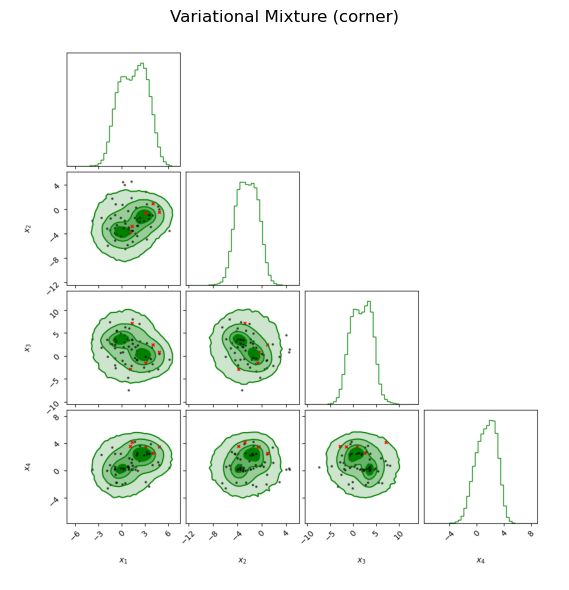

100%|██████████| 240/240 [00:15<00:00, 15.52it/s]


Beggining Iter 13
Iter 13, 1250: ELBO = -0.5318, ELCBO = -0.6716
Iter 13, 2500: ELBO = -0.5008, ELCBO = -0.6421
Iter 13, 3750: ELBO = -0.4837, ELCBO = -0.6281
Iter 13, 5000: ELBO = -0.4730, ELCBO = -0.6240
Iter 13, 6250: ELBO = -0.4487, ELCBO = -0.6105
Iter 13, 7500: ELBO = -0.4370, ELCBO = -0.6142
Iter 13, 8750: ELBO = -0.4143, ELCBO = -0.6143
Iter 13, 10000: ELBO = -0.4044, ELCBO = -0.5902
Current Weights:
[0.12318137 0.14963993 0.11556128 0.11102606 0.13669798 0.15145448
 0.05582274 0.15661616]

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Adding new component.
Plot After Iter 13 showing new training points



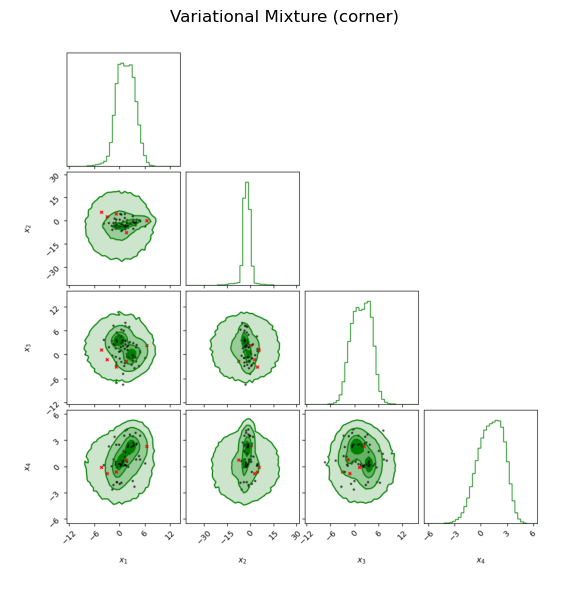

100%|██████████| 240/240 [00:20<00:00, 11.70it/s]


Beggining Iter 14
Iter 14, 1250: ELBO = -0.6051, ELCBO = -0.9698
Iter 14, 2500: ELBO = -0.5720, ELCBO = -0.8146
Iter 14, 3750: ELBO = -0.5457, ELCBO = -0.7410
Iter 14, 5000: ELBO = -0.5366, ELCBO = -0.7069
Iter 14, 6250: ELBO = -0.5367, ELCBO = -0.6946
Iter 14, 7500: ELBO = -0.5107, ELCBO = -0.6606
Iter 14, 8750: ELBO = -0.5183, ELCBO = -0.6633
Iter 14, 10000: ELBO = -0.5089, ELCBO = -0.6433
Current Weights:
[0.10741319 0.15144503 0.10443351 0.10619249 0.12128891 0.15178649
 0.04189015 0.17560429 0.03994595]

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Adding new component.
Plot After Iter 14 showing new training points



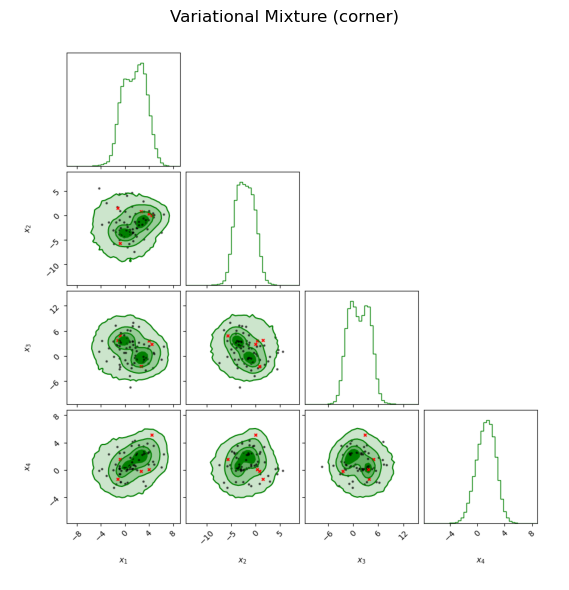

100%|██████████| 240/240 [00:22<00:00, 10.68it/s]


Beggining Iter 15
Iter 15, 1250: ELBO = -0.5187, ELCBO = -0.6524
Iter 15, 2500: ELBO = -0.5046, ELCBO = -0.6386
Iter 15, 3750: ELBO = -0.5023, ELCBO = -0.6371
Iter 15, 5000: ELBO = -0.4951, ELCBO = -0.6308
Iter 15, 6250: ELBO = -0.4954, ELCBO = -0.6322
Iter 15, 7500: ELBO = -0.4798, ELCBO = -0.6190
Iter 15, 8750: ELBO = -0.4928, ELCBO = -0.6348
Iter 15, 10000: ELBO = -0.4860, ELCBO = -0.6236
Current Weights:
[0.08518494 0.14386817 0.08866035 0.09719085 0.10116137 0.14146584
 0.03183304 0.18027497 0.02816681 0.10219366]

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Adding new component.
Plot After Iter 15 showing new training points



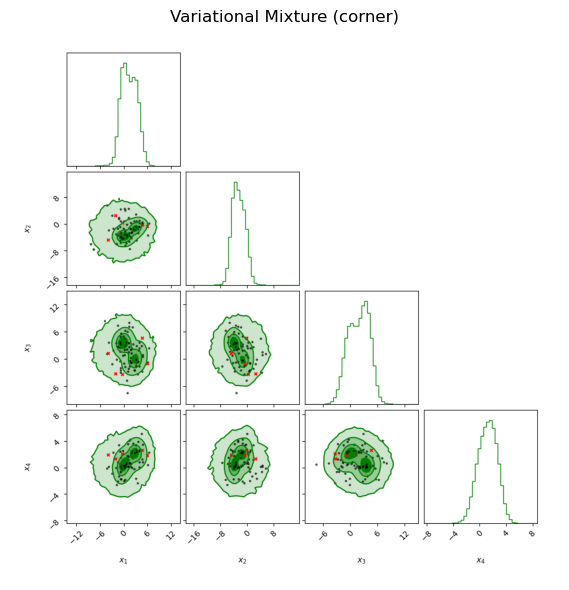

100%|██████████| 80/80 [00:07<00:00, 10.42it/s]


Beggining Iter 16
Iter 16, 1250: ELBO = -0.4665, ELCBO = -0.5717
Iter 16, 2500: ELBO = -0.4546, ELCBO = -0.5595
Iter 16, 3750: ELBO = -0.4485, ELCBO = -0.5530
Iter 16, 5000: ELBO = -0.4351, ELCBO = -0.5397
Iter 16, 6250: ELBO = -0.4347, ELCBO = -0.5393
Iter 16, 7500: ELBO = -0.4279, ELCBO = -0.5319
Iter 16, 8750: ELBO = -0.4137, ELCBO = -0.5175
Iter 16, 10000: ELBO = -0.4267, ELCBO = -0.5301
Current Weights:
[0.06409823 0.12837905 0.07313247 0.08353255 0.08183451 0.12238347
 0.02388867 0.17360589 0.01967694 0.09521301 0.13425522]

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Adding new component.
Plot After Iter 16 showing new training points



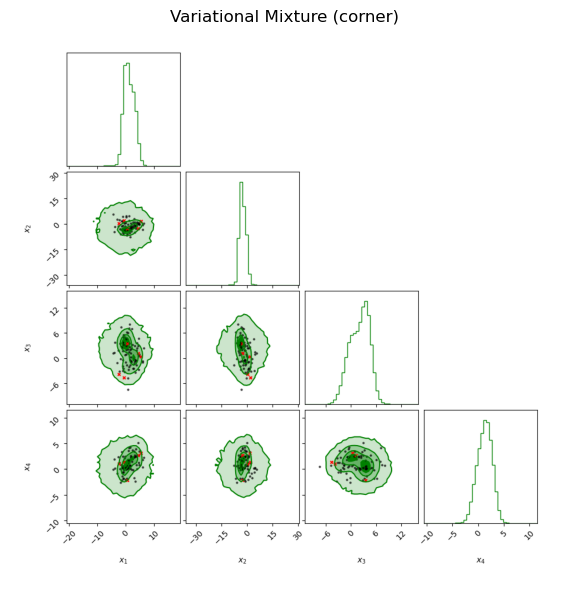

100%|██████████| 80/80 [00:08<00:00,  9.57it/s]


Beggining Iter 17
Iter 17, 1250: ELBO = -0.5555, ELCBO = -0.6579
Iter 17, 2500: ELBO = -0.5132, ELCBO = -0.6132
Iter 17, 3750: ELBO = -0.4957, ELCBO = -0.5955
Iter 17, 5000: ELBO = -0.4722, ELCBO = -0.5721
Iter 17, 6250: ELBO = -0.4640, ELCBO = -0.5646
Iter 17, 7500: ELBO = -0.4496, ELCBO = -0.5513
Iter 17, 8750: ELBO = -0.4419, ELCBO = -0.5453
Iter 17, 10000: ELBO = -0.4301, ELCBO = -0.5331
Current Weights:
[0.04928774 0.11165016 0.06407588 0.0718134  0.06687687 0.11101055
 0.01882989 0.16919298 0.01493578 0.08718965 0.13048869 0.10464843]

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Adding new component.
Plot After Iter 17 showing new training points



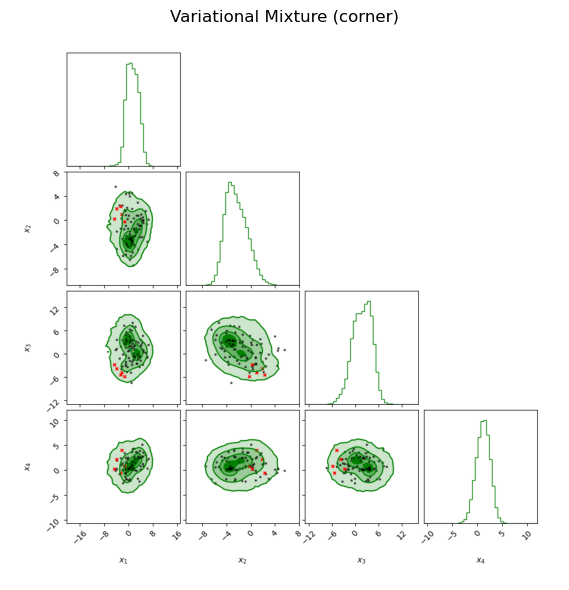

100%|██████████| 80/80 [00:08<00:00,  9.66it/s]


Beggining Iter 18
Iter 18, 1250: ELBO = -0.4455, ELCBO = -0.5191
Iter 18, 2500: ELBO = -0.4275, ELCBO = -0.5001
Iter 18, 3750: ELBO = -0.4020, ELCBO = -0.4740
Iter 18, 5000: ELBO = -0.3949, ELCBO = -0.4667
Iter 18, 6250: ELBO = -0.3883, ELCBO = -0.4600
Iter 18, 7500: ELBO = -0.3964, ELCBO = -0.4677
Iter 18, 8750: ELBO = -0.3709, ELCBO = -0.4424
Iter 18, 10000: ELBO = -0.3718, ELCBO = -0.4429
Current Weights:
[0.04232285 0.09568811 0.05797423 0.06422403 0.05672985 0.10317716
 0.01582543 0.17671533 0.01226751 0.08042812 0.13718084 0.09535249
 0.06211406]

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Adding new component.
Plot After Iter 18 showing new training points



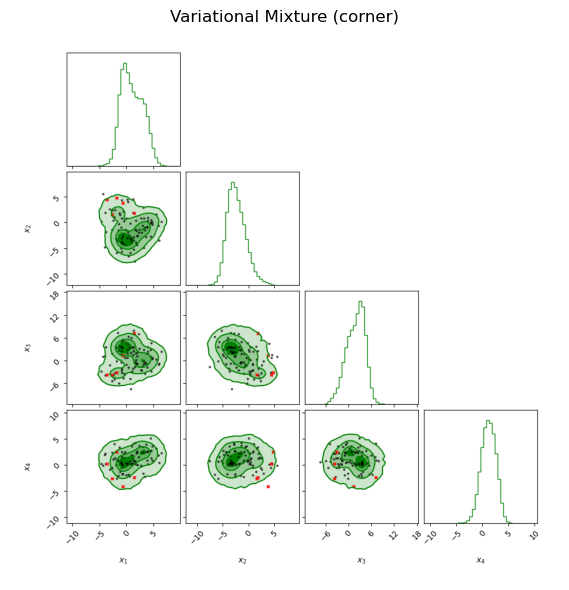

100%|██████████| 80/80 [00:08<00:00,  8.96it/s]


Beggining Iter 19
Iter 19, 1250: ELBO = -0.4178, ELCBO = -0.5305
Iter 19, 2500: ELBO = -0.4174, ELCBO = -0.5281
Iter 19, 3750: ELBO = -0.3940, ELCBO = -0.5041
Iter 19, 5000: ELBO = -0.3975, ELCBO = -0.5075
Iter 19, 6250: ELBO = -0.3897, ELCBO = -0.5003
Iter 19, 7500: ELBO = -0.3980, ELCBO = -0.5084
Iter 19, 8750: ELBO = -0.3890, ELCBO = -0.4994
Iter 19, 10000: ELBO = -0.3926, ELCBO = -0.5046
Current Weights:
[0.03475478 0.07598555 0.04940486 0.0548783  0.04491435 0.08806436
 0.01260952 0.17272762 0.00960931 0.06754775 0.13584745 0.0791106
 0.05109063 0.12345492]
Removing 1 components

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Adding new component.
Plot After Iter 19 showing new training points



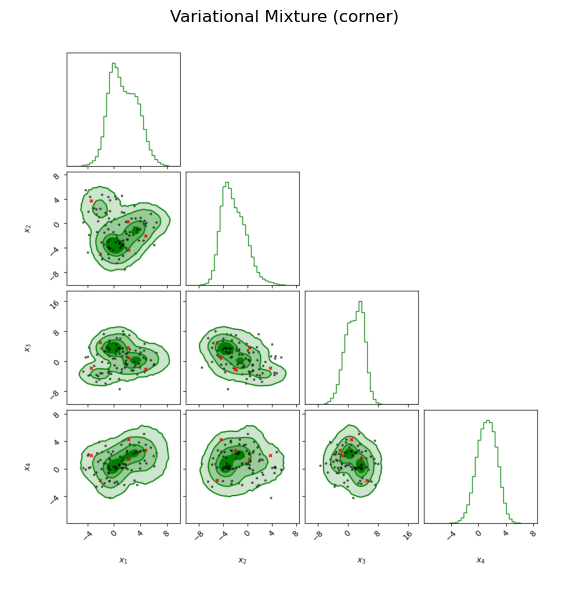

100%|██████████| 80/80 [00:08<00:00,  8.93it/s]


Beggining Iter 20
Iter 20, 1250: ELBO = -0.4369, ELCBO = -0.5136
Iter 20, 2500: ELBO = -0.4176, ELCBO = -0.4924
Iter 20, 3750: ELBO = -0.4283, ELCBO = -0.5019
Iter 20, 5000: ELBO = -0.4109, ELCBO = -0.4840
Iter 20, 6250: ELBO = -0.4100, ELCBO = -0.4826
Iter 20, 7500: ELBO = -0.4206, ELCBO = -0.4928
Iter 20, 8750: ELBO = -0.4122, ELCBO = -0.4844
Iter 20, 10000: ELBO = -0.4182, ELCBO = -0.4908
Current Weights:
[0.03169997 0.06625353 0.04673852 0.05210466 0.04046229 0.08107755
 0.01113226 0.18792047 0.06025324 0.14416482 0.0727072  0.04597003
 0.11892651 0.04058894]

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Adding new component.
Plot After Iter 20 showing new training points



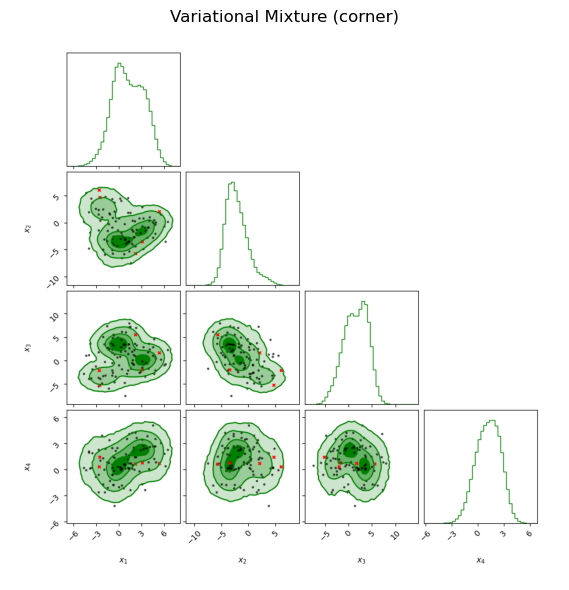

100%|██████████| 80/80 [00:09<00:00,  8.16it/s]


Beggining Iter 21
Jittered Candidate Selected
Iter 21, 1250: ELBO = -0.3409, ELCBO = -0.4453
Iter 21, 2500: ELBO = -0.3225, ELCBO = -0.4269
Iter 21, 3750: ELBO = -0.3279, ELCBO = -0.4331
Iter 21, 5000: ELBO = -0.3239, ELCBO = -0.4299
Iter 21, 6250: ELBO = -0.3203, ELCBO = -0.4269
Iter 21, 7500: ELBO = -0.3209, ELCBO = -0.4280
Iter 21, 8750: ELBO = -0.3175, ELCBO = -0.4251
Iter 21, 10000: ELBO = -0.3263, ELCBO = -0.4357
Current Weights:
[0.02887746 0.05727721 0.04564933 0.04927956 0.036204   0.0737151
 0.00981588 0.20278652 0.05264627 0.15558457 0.06480415 0.04155399
 0.11690283 0.03622645 0.02867668]
Removing 1 components

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Adding new component.
Plot After Iter 21 showing new training points



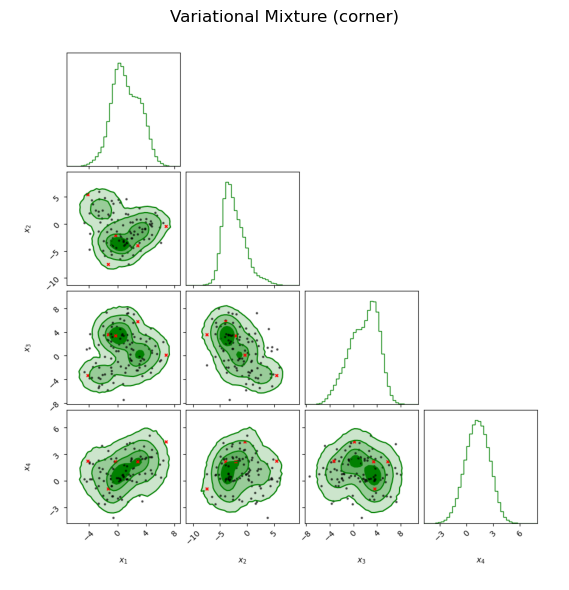

100%|██████████| 80/80 [00:10<00:00,  7.82it/s]


Beggining Iter 22
Iter 22, 1250: ELBO = -0.3752, ELCBO = -0.4514
Iter 22, 2500: ELBO = -0.3642, ELCBO = -0.4382
Iter 22, 3750: ELBO = -0.3550, ELCBO = -0.4282
Iter 22, 5000: ELBO = -0.3446, ELCBO = -0.4178
Iter 22, 6250: ELBO = -0.3514, ELCBO = -0.4246
Iter 22, 7500: ELBO = -0.3397, ELCBO = -0.4130
Iter 22, 8750: ELBO = -0.3407, ELCBO = -0.4142
Iter 22, 10000: ELBO = -0.3414, ELCBO = -0.4159
Current Weights:
[0.02392273 0.04501939 0.04004938 0.04248168 0.02947152 0.05958785
 0.1917855  0.04106884 0.14815611 0.05306039 0.03394509 0.09960132
 0.02944941 0.02364329 0.13875751]

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Adding new component.
Plot After Iter 22 showing new training points



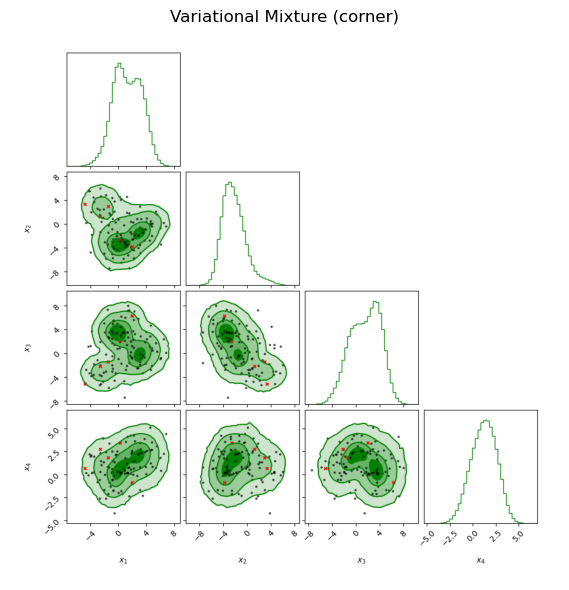

100%|██████████| 80/80 [00:10<00:00,  7.65it/s]


Beggining Iter 23
Jittered Candidate Selected
Iter 23, 1250: ELBO = -0.3350, ELCBO = -0.3901
Iter 23, 2500: ELBO = -0.3282, ELCBO = -0.3828
Iter 23, 3750: ELBO = -0.3262, ELCBO = -0.3807
Iter 23, 5000: ELBO = -0.3254, ELCBO = -0.3799
Iter 23, 6250: ELBO = -0.3149, ELCBO = -0.3696
Iter 23, 7500: ELBO = -0.3188, ELCBO = -0.3735
Iter 23, 8750: ELBO = -0.3140, ELCBO = -0.3688
Iter 23, 10000: ELBO = -0.3250, ELCBO = -0.3807
Current Weights:
[0.02183073 0.0382133  0.03861604 0.04038516 0.02642321 0.0529368
 0.19965933 0.03515698 0.15665474 0.04713935 0.03033065 0.09383121
 0.02655321 0.02154269 0.13263708 0.0380895 ]

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Adding new component.
Plot After Iter 23 showing new training points



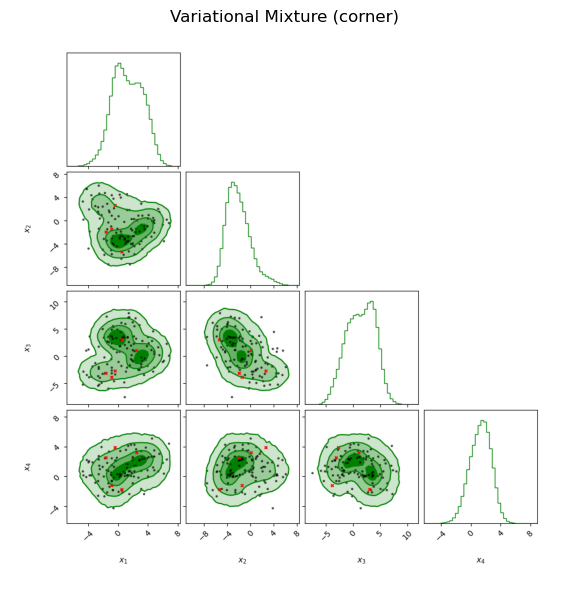

100%|██████████| 80/80 [00:10<00:00,  7.34it/s]


Beggining Iter 24
Jittered Candidate Selected
Iter 24, 1250: ELBO = -0.2827, ELCBO = -0.3396
Iter 24, 2500: ELBO = -0.2846, ELCBO = -0.3408
Iter 24, 3750: ELBO = -0.2796, ELCBO = -0.3353
Iter 24, 5000: ELBO = -0.2640, ELCBO = -0.3197
Iter 24, 6250: ELBO = -0.2715, ELCBO = -0.3273
Iter 24, 7500: ELBO = -0.2728, ELCBO = -0.3285
Iter 24, 8750: ELBO = -0.2687, ELCBO = -0.3244
Iter 24, 10000: ELBO = -0.2703, ELCBO = -0.3264
Current Weights:
[0.01981352 0.03196012 0.03675517 0.03820398 0.0234835  0.04654975
 0.21531722 0.03042832 0.16596604 0.04151643 0.02687371 0.08814039
 0.02376957 0.01963531 0.12499696 0.03547192 0.03111808]

Beginning active sampling for next Iter
Point 1 of 5
Point 2 of 5
Point 3 of 5
Point 4 of 5
Point 5 of 5
Completed active sampling for next Iter

Adding new component.
Plot After Iter 24 showing new training points



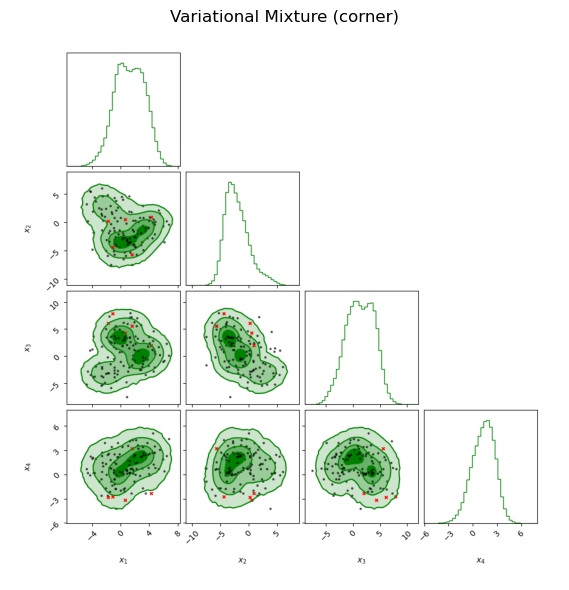

100%|██████████| 80/80 [00:11<00:00,  7.00it/s]


Beggining Iter 25
Jittered Candidate Selected
Iter 25, 1250: ELBO = -0.2692, ELCBO = -0.3302
Iter 25, 2500: ELBO = -0.2643, ELCBO = -0.3264
Iter 25, 3750: ELBO = -0.2574, ELCBO = -0.3199
Iter 25, 5000: ELBO = -0.2554, ELCBO = -0.3178
Iter 25, 6250: ELBO = -0.2516, ELCBO = -0.3142
Iter 25, 7500: ELBO = -0.2634, ELCBO = -0.3265
Iter 25, 8750: ELBO = -0.2541, ELCBO = -0.3170
Iter 25, 10000: ELBO = -0.2599, ELCBO = -0.3238


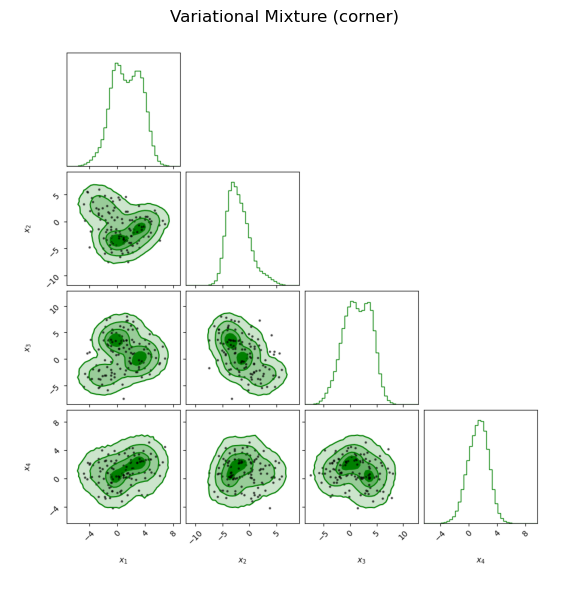

In [14]:

grad_elbo = jit(
    grad(lambda *args, **kwargs: elbo(*args, **kwargs)[0]),
    static_argnames=['fullsig']
)


seed = int(time.time()*1e6)
key = jax.random.PRNGKey(seed)

# current bounds
PLB = jnp.array([-3, -4, -4, -3])
PUB = jnp.array([4, 3, 4, 4])
range_ = PUB - PLB
extension = 0.5*range_
lower = PLB - extension
upper = PUB + extension



params, elbo_history, elcbo_history = vbmc(
    grad_elbo, d=4, PLB=PLB, PUB=PUB, lower=lower, upper=upper, n_initial=8,
    alpha=1, beta=0.3, gamma=0.4,
    lr=0.001, k=2, n_points=5,
    rsp=3, n1=25, n2=10_000, 
    plots=True, ll=expensive_log_likelihood, 
    params_true=params_true,
    key=key,fullsig=True)


#### Corner plot comparison

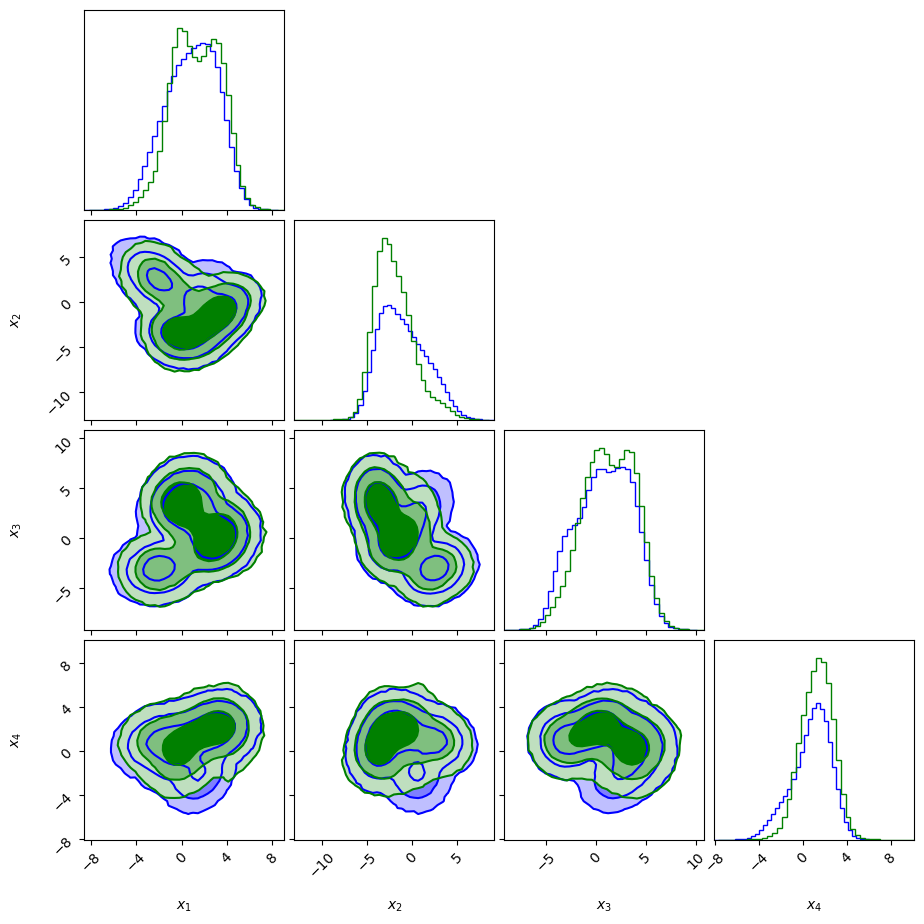

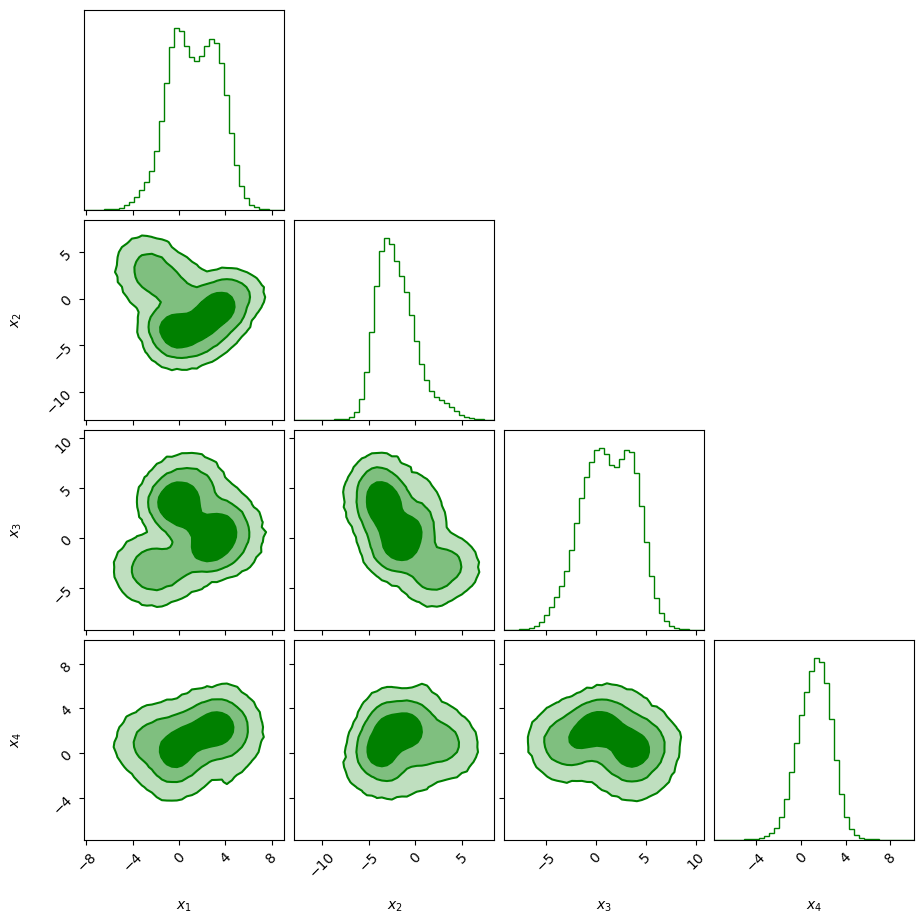

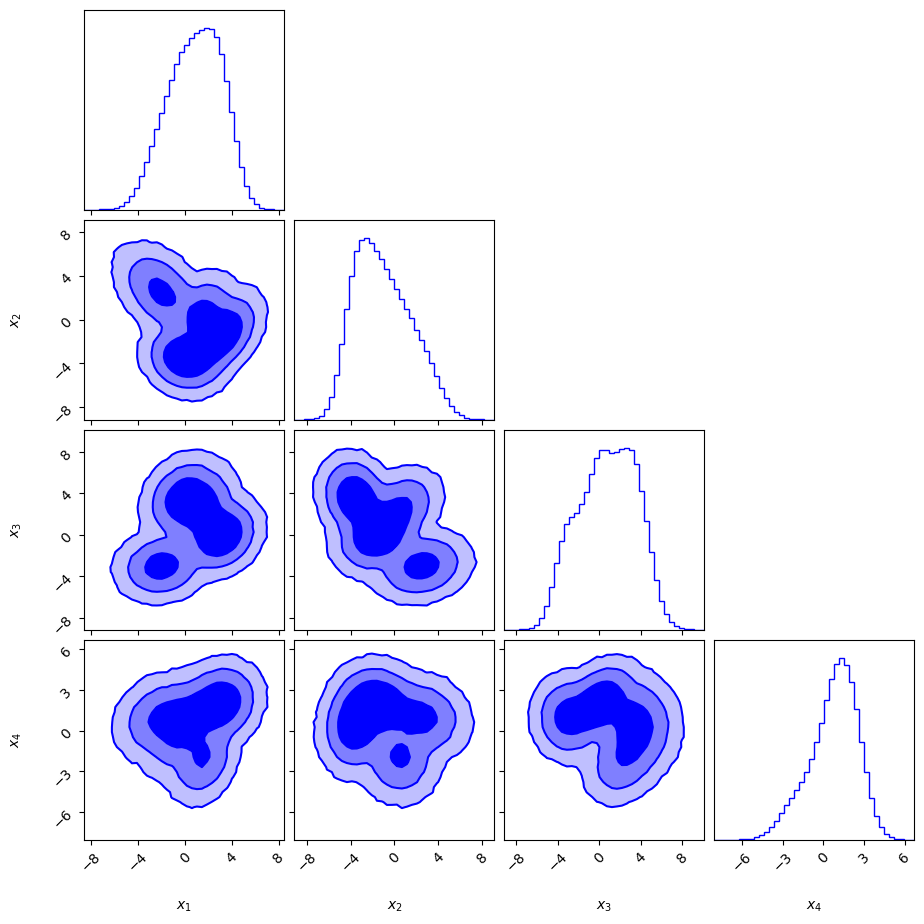

In [22]:
def sample_from_mixture(mu, covs, weights, n_samples=5000, key=None):
    K = len(weights)
    # choose components according to mixture weights
    component_choices = np.random.choice(K, size=n_samples, p=np.array(weights))
    samples = []
    for k in range(K):
        n_k = np.sum(component_choices == k)
        if n_k > 0:
            samp = np.random.multivariate_normal(np.array(mu[k]), np.array(covs[k]), size=n_k)
            samples.append(samp)
    return np.vstack(samples)



# ----- True mixture -----
mu_true, s_true, weights_true = params_true
true_samples = sample_from_mixture(mu_true, s_true, weights_true, n_samples=1_000_000)


# ----- Variational mixture -----
means = params[0]
vars_ = jnp.exp(params[1])
weights = jnp.exp(params[2]) / jnp.sum(jnp.exp(params[2]))

n_samples = 1_000_000
dim = means.shape[1]

components = np.random.choice(len(weights), size=n_samples, p=np.array(weights))
samples2 = np.zeros((n_samples, dim))
for i in range(len(weights)):
    mask = (components == i)
    n_i = np.sum(mask)
    if n_i > 0:
        samples2[mask] = np.random.normal(loc=means[i], scale=np.sqrt(vars_[i]), size=(n_i, dim))


# ----- Plot both -----
labels = [r"$x_1$", r"$x_2$", r"$x_3$", r"$x_4$", r"$x_5$", r"$x_6$", r"$x_7$"]

# Plot true distribution first
figure = corner.corner(
    true_samples,
    bins=40,
    labels=labels,
    plot_datapoints=False,
    fill_contours=True,
    levels=(0.67, 0.95, 0.997),
    alpha=0.1,
    color='blue'
)

# Overlay variational mixture
figure = corner.corner(
    samples2,
    bins=40,
    labels=labels,
    plot_datapoints=False,
    fill_contours=True,
    levels=(0.67, 0.95, 0.997),
    alpha=0.5,
    color='green',
    fig=figure
)

plt.show()


# Overlay variational mixture
figure = corner.corner(
    samples2,
    bins=40,
    labels=labels,
    plot_datapoints=False,
    fill_contours=True,
    levels=(0.67, 0.95, 0.997),
    alpha=0.5,
    color='green'
)
plt.show()

# Plot true distribution first
figure = corner.corner(
    true_samples,
    bins=40,
    labels=labels,
    plot_datapoints=False,
    fill_contours=True,
    levels=(0.67, 0.95, 0.997),
    alpha=0.1,
    color='blue'
)
plt.show()


#### ELBO Convergence

Estimated ELBO: -0.273143876456021


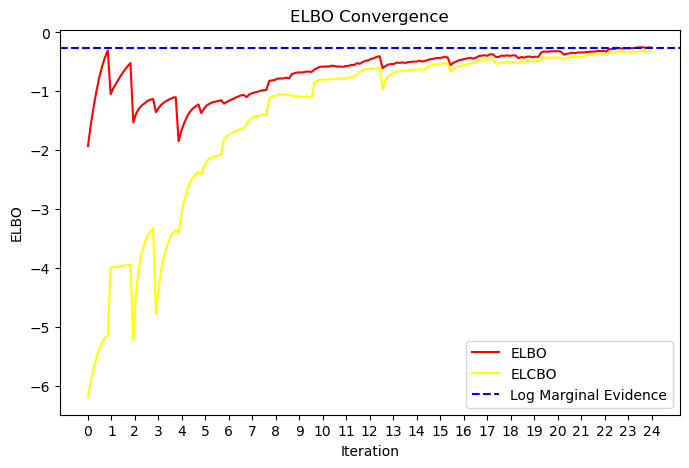

In [24]:

def log_mixture_density(x, means, covs, weights):
    """Compute log p(x) for a Gaussian mixture model."""
    K = len(weights)
    pdf_vals = np.zeros((x.shape[0], K))
    for k in range(K):
        pdf_vals[:, k] = weights[k] * multivariate_normal.pdf(x, mean=means[k], cov=covs[k])
    return np.log(np.sum(pdf_vals, axis=1) + 1e-300)  # stability

def estimate_elbo(params_q, params_p, n_samples=50000):
    """Monte Carlo estimate of ELBO = E_q[log p(z) - log q(z)]"""
    mu_q, vars_q, weights_q = params_q
    mu_p, covs_p, weights_p = params_p
    weights_q = jnp.exp(weights_q) / jnp.sum(jnp.exp(weights_q))

    
    covs_q = [np.eye(mu_q.shape[1]) * v for v in np.exp(vars_q)]
    
    # Sample from q
    K = len(weights_q)
    comp_idx = np.random.choice(K, size=n_samples, p=np.array(weights_q))
    samples = []
    for k in range(K):
        n_k = np.sum(comp_idx == k)
        if n_k > 0:
            s = np.random.multivariate_normal(mu_q[k], covs_q[k], size=n_k)
            samples.append(s)
    z_samples = np.vstack(samples)
    
    # Compute log p(z) and log q(z)
    log_p = log_mixture_density(z_samples, mu_p, covs_p, weights_p)
    log_q = log_mixture_density(z_samples, mu_q, covs_q, weights_q)
    
    return np.mean(log_p - log_q)


elbo_value = estimate_elbo(params_q=params, params_p=params_true, n_samples=10_000_000)
print("Estimated ELBO:", elbo_value)

plt.figure(figsize=(8,5))
plt.plot(elbo_history, label='ELBO', color='red')
plt.plot(elcbo_history, label='ELCBO', color='yellow')

# Add horizontal line
plt.axhline(y=elbo_value, color='blue', linestyle='--', label='Log Marginal Evidence')

# Set x-axis to 0–15 without slicing data
plt.xticks(np.linspace(0, len(elbo_history)-1, 25), labels=np.arange(0,25))

#plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.title("ELBO Convergence")
plt.legend()
plt.show()